<a href="https://colab.research.google.com/github/juliancramos/cnn-pneumonia-covid-detector/blob/main/cnn-pneumonia-covid-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Classification: Normal vs. Pneumonia vs. COVID-19

**Authors:** Sergio Ortíz - Julián Ramos - Melissa Ruiz

**Course:** Machine Learning Techniques

**Date:** February 2026

## 1. Executive Summary
Lung diseases such as Pneumonia and COVID-19 are critical health conditions requiring timely diagnosis. Traditional manual interpretation of chest X-rays is subjective and prone to error.

This project aims to develop an automated Deep Learning system using **Convolutional Neural Networks (CNNs)** to classify chest X-ray images into three categories:
1.  **Normal**
2.  **Pneumonia**
3.  **COVID-19**

---
### 1.1 Project Objectives
This project follows a structured workflow designed to meet specific technical requirements:

1.  **Exploratory Data Analysis (EDA):**
    * Explore the dataset to identify key characteristics, including class distribution and image quality.
    * Detect potential biases (e.g., class imbalance) and present visualizations to support design decisions.

2.  **Image Preprocessing:**
    * Implement techniques to improve input quality, such as pixel normalization and resizing.
    * Apply **Data Augmentation** strategies to improve model generalization and prevent overfitting.
    * Justify how these steps prepare the data for the neural network.

3.  **Neural Network Design:**
    * Design a custom **Convolutional Neural Network (CNN)** architecture suitable for classification.
    * Justify the selection of layers (Convolutional, Pooling, Fully Connected), filter sizes, and activation functions.
    * Present the architecture diagram and explain its expected behavior.

4.  **Training and Evaluation:**
    * Train the model using an appropriate optimization strategy and loss function.
    * Evaluate performance on a validation set using robust metrics such as **Precision, Recall, and F1-Score**.
    * Analyze results to identify issues like overfitting and propose technical solutions.

## 2. Environment Setup and Configuration

In this section, the execution environment is configured.

### 2.1 Technical Stack
* **Data Manipulation:** `pandas` and `numpy` are utilized for metadata handling and numerical operations.
* **Visualization:** `matplotlib` and `seaborn` are employed to analyze data distributions and training metrics.
* **Image Processing:** `cv2` (OpenCV) is used for reading and resizing X-ray images.
* **Deep Learning:** `tensorflow` and `keras` serve as the core framework for constructing the CNN.



In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

# CONSTANTS CONFIGURATION
# Fixed seed to ensure reproducibility (weights)
SEED = 42
# Target image resolution (224x224 pixels)
IMG_SIZE = 224
# Number of images processed per iteration
BATCH_SIZE = 32

def set_seed(seed_value):
    """
    Sets the random seed for reproducibility across all libraries.

    This function locks the pseudo-random number generators of Python, NumPy,
    and TensorFlow to a specific sequence.

    Args:
        seed_value (int): The seed number to initialize generators.
    """
    # Python's built-in hashing (dictionaries/sets)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # Python's standard random library (shuffle, choice)
    random.seed(seed_value)

    # NumPy's random module (array splitting, matrices)
    np.random.seed(seed_value)

    # TensorFlow's random module (weight initialization)
    tf.random.set_seed(seed_value)

# Apply the configuration
set_seed(SEED)

# Visualization Setup
# Set a style for all plots (background grid)
sns.set_style("whitegrid")

# Define a global figure size (12x6 inches)
plt.rcParams['figure.figsize'] = (12, 6)

# Silence non-critical alerts (DeprecationWarnings)
warnings.filterwarnings('ignore')

print("Environment setup complete.")
print(f"TensorFlow Version: {tf.__version__}")

Environment setup complete.
TensorFlow Version: 2.19.0


## 3. Data Ingestion

In this section, the required datasets are downloaded from Kaggle.

The Kaggle API (`kaggle.json`) is utilized because the dataset consists of **unstructured image data** organized in directory trees, rather than structured tabular files (e.g., CSV or Excel).
**Datasets acquired:**
* **Chest X-Ray Images (Pneumonia):** provided by Paul Mooney.
* **COVID-19 Radiography Database:** provided by Tawsifur Rahman.

In [2]:
import os
from google.colab import drive

def setup_kaggle_from_drive():
    """
    Configures the Kaggle API by loading the token from Google Drive.

    This function mounts the user's Google Drive, looks for 'kaggle.json'
    in the root directory ('/content/drive/MyDrive/'), and download the datasets.
    """

    # Validate if data already exists
    if os.path.exists('chest_xray') and os.path.exists('COVID-19_Radiography_Dataset'):
        print("Data already exists. Skipping download and extraction.")
        return

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Path to the token in Drive
    drive_path = '/content/drive/MyDrive/kaggle.json'
    #local_path = '/root/.kaggle/kaggle.json'

    # Check and Copy Credentials
    if not os.path.exists(drive_path):
        print(f"Error: 'kaggle.json' not found at {drive_path}.")
        print("Upload the file to your Google Drive root folder.")
        return

    # Create the hidden directory .kaggle
    !mkdir -p ~/.kaggle

    # Copy the file from Drive to the local Colab environment
    !cp "$drive_path" ~/.kaggle/

    # Set security permissions (Required by Kaggle API)
    !chmod 600 ~/.kaggle/kaggle.json
    print("API Token loaded from Drive successfully.")

    # Dataset Download & Extraction
    print("\nDownloading Datasets...")

    print("Downloading Chest X-Ray Images (Pneumonia)...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

    print("Downloading COVID-19 Radiography Database...")
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database --force

    print("\nExtracting Files...")
    # Unzip
    !unzip -qo chest-xray-pneumonia.zip
    !unzip -qo covid19-radiography-database.zip

    print("SUCCESS: Data ingestion complete.")

# Execute the function
setup_kaggle_from_drive()

Mounting Google Drive...
Mounted at /content/drive
API Token loaded from Drive successfully.

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:23<00:00, 112MB/s] 
100% 2.29G/2.29G [00:23<00:00, 104MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 773M/778M [00:03<00:00, 124MB/s] 
100% 778M/778M [00:04<00:00, 202MB/s]

Extracting Files...
SUCCESS: Data ingestion complete.


## 4. Data Processing
The data comes from two different sources with distinct directory structures. In this section, it is unified into a single DataFrame.

**Process:**
1.  **Cleanup:** Remove temporary `.zip` files to free up disk space.
2.  **Path Extraction:** Traverse the directory trees of both datasets.
3.  **Labeling:** Assign standardized labels (`COVID-19`, `NORMAL`, `PNEUMONIA`) based on the folder source.
4.  **Consolidation:** Create a Pandas DataFrame containing all file paths and labels for easy manipulation.

### 4.1 Initialization and Environment Cleanup
Before processing, the environment is prepared by importing necessary libraries ( `pathlib`, `os`). Additionally, the source `.zip` archives are removed from the working directory to release disk space.

Global lists `image_paths` and `labels` are initialized here to serve as the accumulators for the subsequent data extraction steps.

In [3]:
import os
from pathlib import Path

# Remove source zip files to save space
if os.path.exists('chest-xray-pneumonia.zip'):
    !rm *.zip
    print("Temporary zip files removed.")

# Initialize storage for the unified dataset
image_paths = []
labels = []

Temporary zip files removed.


### 4.2 Processing COVID-19 Radiography Dataset
This dataset is organized into four distinct folders: `COVID`, `Normal`, `Lung_Opacity`, and `Viral Pneumonia`.

**Class Selection:**

1.  **`COVID` (Selected):** Represents the positive class for the detection target.
2.  **`Normal` (Selected):** These images are included to supplement the `NORMAL` class from the second dataset. Combining healthy samples from both sources.
3. **`Lung_Opacity` (Excluded):** This folder is removed. “Lung Opacity” is a general label that can point to pneumonia, pulmonary edema, lung cancer, or other issues. Keeping it as a separate class from “Pneumonia” or “COVID-19” would add ambiguity.

4. **`Viral Pneumonia` (Included):** This folder is included and merged into the general `PNEUMONIA` class. By incorporating these 1,345 additional samples, the diversity of the pneumonia dataset is increased.

In [4]:
# COVID-19 Radiography Dataset
# Extract 'COVID' and 'Normal'
print("Processing COVID-19 Radiography Dataset...")

# Class: COVID-19
covid_path = Path("COVID-19_Radiography_Dataset/COVID/images")
covid_files = list(covid_path.glob('*.*')) #any file type
image_paths.extend([str(path) for path in covid_files])
labels.extend(['COVID-19'] * len(covid_files))
print(f"-> Added {len(covid_files)} COVID-19 images.")

# Class: Normal
normal_covid_path = Path("COVID-19_Radiography_Dataset/Normal/images")
normal_covid_files = list(normal_covid_path.glob('*.*'))
image_paths.extend([str(path) for path in normal_covid_files])
labels.extend(['NORMAL'] * len(normal_covid_files))
print(f"-> Added {len(normal_covid_files)} Normal images from COVID-19 dataset")

# Class: Viral Pneumonia
# These images are added to the PNEUMONIA label to increase its sample size
viral_pneumo_path = Path("COVID-19_Radiography_Dataset/Viral Pneumonia/images")
viral_files = list(viral_pneumo_path.glob('*.*'))
image_paths.extend([str(path) for path in viral_files])
labels.extend(['PNEUMONIA'] * len(viral_files))
print(f"-> Added {len(viral_files)} Viral Pneumonia images to the PNEUMONIA class.")

Processing COVID-19 Radiography Dataset...
-> Added 3616 COVID-19 images.
-> Added 10192 Normal images from COVID-19 dataset
-> Added 1345 Viral Pneumonia images to the PNEUMONIA class.


### 4.3 Processing Chest X-Ray (Pneumonia) Dataset
This dataset follows a standard machine learning directory structure, split into `train`, `test`, and `val` folders, each containing subdirectories for `PNEUMONIA` and `NORMAL`.

**Extraction Strategy:**
Since the goal is to create a unified DataFrame for a custom split later, the code ignores the original pre-split structure. An iteration is performed over all subdirectories (`train`, `test`, `val`) to aggregate every image into a list.



In [5]:
# Chest X-Ray (Pneumonia) Dataset
print("\n--- Processing Chest X-Ray (Pneumonia) Dataset ---")
pneumonia_path = Path("chest_xray")

# Initialize counters
count_normal = 0
count_pneumonia = 0

# Loop through the training, testing, and validation folders
for split in ['train', 'test', 'val']:
    # Loop through both classes inside each folder
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = pneumonia_path / split / class_name

        # Search for all possible image extensions to avoid missing any files
        files = list(class_path.glob('*.jpeg')) + \
                list(class_path.glob('*.jpg')) + \
                list(class_path.glob('*.png'))

        # Add them to the main lists
        image_paths.extend([str(path) for path in files])
        labels.extend([class_name] * len(files))

        # Update specific counters
        if class_name == 'NORMAL':
            count_normal += len(files)
        elif class_name == 'PNEUMONIA':
            count_pneumonia += len(files)

        print(f"-> Added {len(files)} images for class '{class_name}' from '{split}' set.")

# Final report for this specific source
print(f"-> Processed all images from Chest X-Ray source.")
print(f"   - Total PNEUMONIA added: {count_pneumonia}")
print(f"   - Total NORMAL added:    {count_normal}")


--- Processing Chest X-Ray (Pneumonia) Dataset ---
-> Added 1341 images for class 'NORMAL' from 'train' set.
-> Added 3875 images for class 'PNEUMONIA' from 'train' set.
-> Added 234 images for class 'NORMAL' from 'test' set.
-> Added 390 images for class 'PNEUMONIA' from 'test' set.
-> Added 8 images for class 'NORMAL' from 'val' set.
-> Added 8 images for class 'PNEUMONIA' from 'val' set.
-> Processed all images from Chest X-Ray source.
   - Total PNEUMONIA added: 4273
   - Total NORMAL added:    1583


### 4.4 DataFrame Consolidation and Shuffling
Finally, the accumulated file paths and their corresponding labels are merged into a Pandas DataFrame.

**Data Shuffling:**

Here, the DataFrame is shuffled (`sample(frac=1)`). When the data is first loaded, the images are grouped by class (for example, all COVID images first, then Normal, then Pneumonia). If the model is trained in that same order, it could struggle to learn properly and end up focusing on one class at a time.

By randomizing the order, each training batch contains a mix of different classes.


In [6]:
# Create DataFrame
df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Apply shuffling to ensure the model does not learn the order of classes
# .sample(frac=1): Shuffles the dataset by returning 100% of the rows in random order.
# random_state=42: Sets a fixed seed to guarantee the random results are reproducible.
# .reset_index(drop=True): Re-indexes the rows from 0 to N.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"DataFrame Created. Total Samples: {len(df)}")
print("-" * 50)
print(df['label'].value_counts())
print("-" * 50)
display(df.head())

DataFrame Created. Total Samples: 21009
--------------------------------------------------
label
NORMAL       11775
PNEUMONIA     5618
COVID-19      3616
Name: count, dtype: int64
--------------------------------------------------


,filepath,label
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
1,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19
3,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
4,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL


## 5. Exploratory Data Analysis (EDA)

This stage examines the dataset to understand its structure and quality before moving on to modeling. The goal is to ensure that the data is consistent and that the labels align with the visual features of the medical images.

**The main objectives of this EDA are:**

1. **Class Distribution:** Identify class imbalances and consider their potential impact on model training.  
2. **Image Quality and Integrity:** Check for blurry images, artifacts, or source-specific patterns.  
3. **Image Size Analysis:** Review image resolutions.


### 5.1 Quantitative Analysis: Class Distribution

The dataset is analyzed to see how many images belong to each class: `NORMAL`, `PNEUMONIA`, and `COVID-19`. Understanding these proportions helps guide decisions for the training process.

* **Effect on Model Training:** Large differences in class sizes can make the model favor the majority class (`NORMAL`), which could reduce its ability to learn features from the less-represented classes.  
* **Choosing Performance Metrics:** When classes are imbalanced, overall accuracy may not be enough. This analysis supports using metrics like F1-Score and Precision-Recall for a clearer picture.  
* **Basis for Balancing Techniques:** The class distribution justifies applying strategies such as class weighting, targeted data augmentation, or undersampling during pre-process.


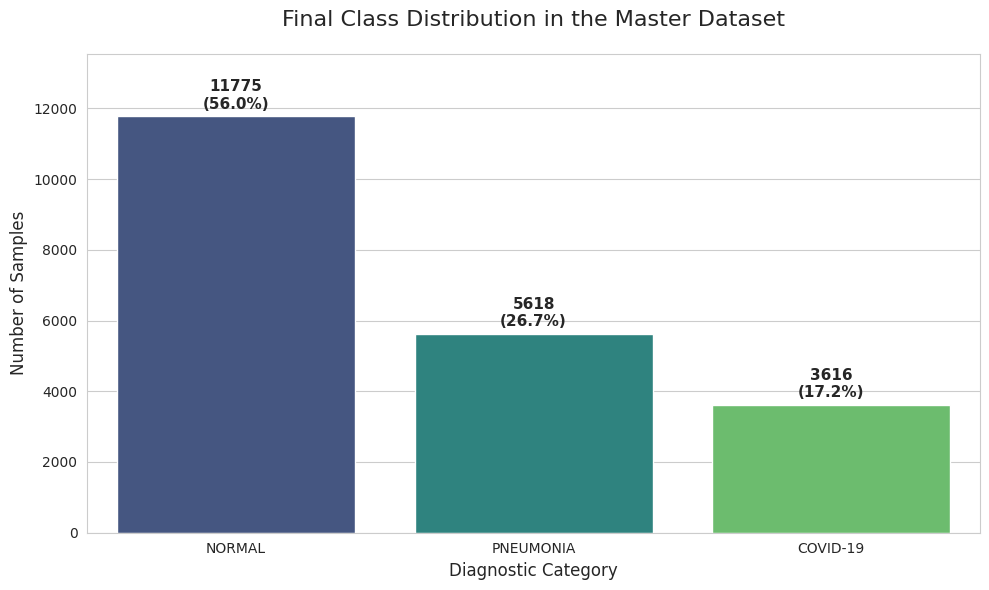

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(dataframe):
    """
    Generates a bar chart to visualize the distribution of classes in the dataset.
    """

    # Calculate counts and percentages
    counts = dataframe['label'].value_counts()
    percentages = (counts / len(dataframe)) * 100

    # Set the visual style
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Create the bar plot
    order = ['NORMAL', 'PNEUMONIA', 'COVID-19']
    ax = sns.countplot(x='label', data=dataframe, palette='viridis',
                       order=order)

    # Title and Labels
    plt.title('Final Class Distribution in the Master Dataset',
              fontsize=16, pad=20)
    plt.xlabel('Diagnostic Category', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)

    # Annotate bars with counts and percentages
    for i, p in enumerate(ax.patches):
        label_count = int(counts[order[i]])
        label_pct = percentages[order[i]]

        # Display text on top of each bar
        ax.annotate(f'{label_count}\n({label_pct:.1f}%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 15),
                    textcoords = 'offset points',
                    fontsize=11, fontweight='bold')

    # Adjust layout to prevent clipping of labels
    plt.ylim(0, max(counts) * 1.15)
    plt.tight_layout()
    plt.show()

# Execute the visualization
plot_class_distribution(df)

### Analysis of Results

The dataset contains a total of 21,009 images, distributed as follows:

* **NORMAL:** 11,775 samples (56.0%)  
* **PNEUMONIA:** 5,618 samples (26.7%)  
* **COVID-19:** 3,616 samples (17.2%)  

The distribution shows a clear class imbalance, with `NORMAL` having more images than the other two classes combined. This imbalance can cause the model to lean toward healthy samples during training. To address this, techniques like **image augmentation** and **class weighting** will be applied to balance the learning process.


### 5.2 Qualitative Analysis: Visual Inspection

In this section, a random sample of images from the `NORMAL`, `PNEUMONIA`, and `COVID-19` categories is displayed. The purpose of this visual check is to evaluate the dataset quality before the training phase begins. This inspection focuses on:

* **Label Integrity:** Confirming that the anatomical patterns in the X-rays correspond to their assigned diagnostic labels.
* **Identification of Artifacts:** Searching for external elements such as medical equipment (cables, electrodes) or text markers ('R', 'L') that could introduce bias into the model.
* **Visual Consistency:** Observing differences in brightness, contrast, and resolution across the different data sources to define pre-processing requirements.

In [8]:
import matplotlib.pyplot as plt
import cv2
import os

def visualize_samples(dataframe, categories, samples_per_category=5):
    """
    Displays a grid of random images for each specified category.

    Args:
        dataframe (pd.DataFrame): The master dataset containing file paths.
        categories (list): List of label names to visualize
        samples_per_category (int): Number of images to show per class.
    """

    # Calculate grid size: Rows = number of classes, Cols = samples per class
    n_rows = len(categories)
    n_cols = samples_per_category

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for i, category in enumerate(categories):
        # Filter the dataframe for the specific class
        class_df = dataframe[dataframe['label'] == category]

        # Take a random sample
        #Try-except block in case a class has fewer images than requested
        try:
            random_samples = class_df.sample(samples_per_category, random_state=42)
        except ValueError:
            random_samples = class_df # Take all if fewer than requested

        for j, (_, row) in enumerate(random_samples.iterrows()):
            img_path = row['filepath']

            # Read image using OpenCV
            img = cv2.imread(img_path)

            if img is not None:
                # Convert from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine current subplot axis
                if n_rows > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j] # Handle case if only 1 category is requested

                # Display image
                ax.imshow(img)
                ax.axis('off') # Hide axes ticks

                # Set title only on the first image of the row
                if j == 0:
                    ax.set_title(f"{category}", fontsize=14, fontweight='bold', pad=10, loc='left')
            else:
                print(f"Could not read image at {img_path}")

    plt.show()

Generating visual inspection grid...


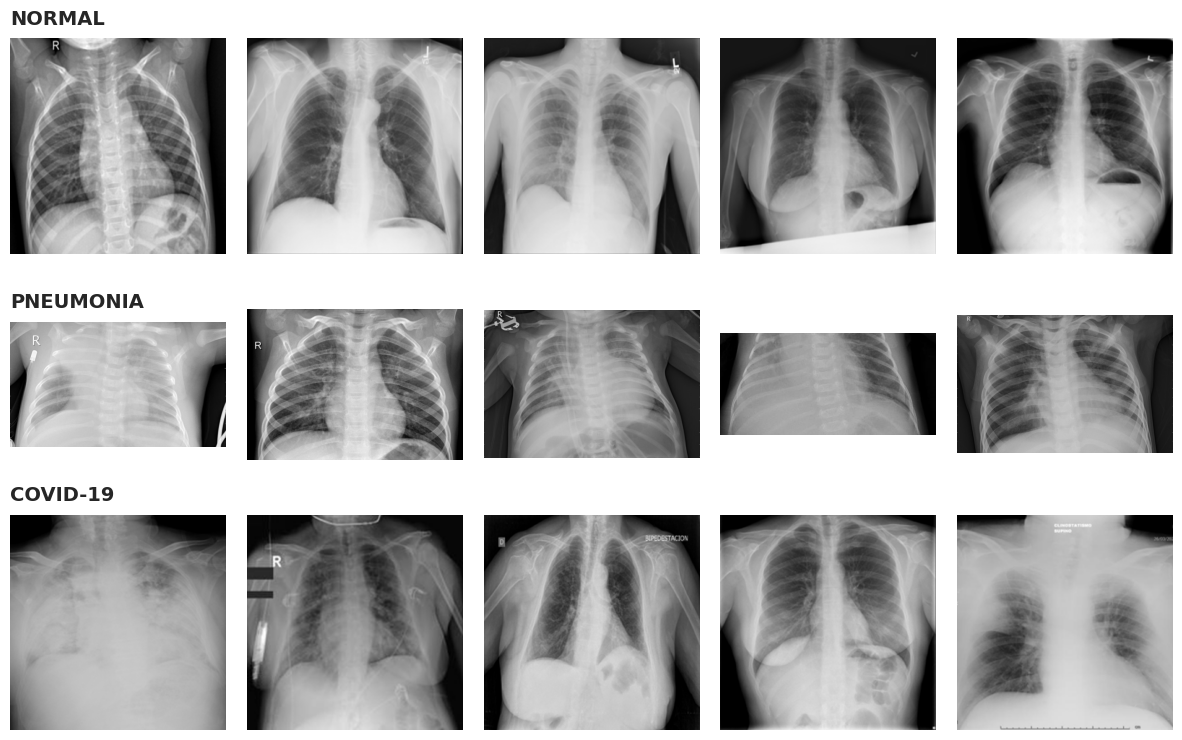

In [9]:
# Define the order of categories to inspect
target_categories = ['NORMAL', 'PNEUMONIA', 'COVID-19']

# Execute the visualization function
print("Generating visual inspection grid...")
visualize_samples(df, target_categories, samples_per_category=5)

### Analysis of Visual Inspection

The review of random samples shows noticeable variability in the images, which points to specific pre-processing needs:

* **Inconsistent Dimensions:** Images have different sizes and shapes, with some being square and others rectangular. All images need to be resized to a standard size of 224x224 pixels before feeding them into the neural network.  
* **Presence of Artifacts:** Some X-rays include medical annotations such as 'R' or 'L', or monitoring equipment like ECG leads and wires, especially in pathological cases. These features could bias the model, which should focus only on lung patterns.  
* **Intensity Variations:** Images differ in brightness and contrast. Some appear faint and low-contrast, while others are clearer. Pixel values should be normalized to a 0-1 range to support stable training.


### 5.3 Quantitative Analysis: Image Dimensions

A statistical analysis of image resolutions is conducted to define the most appropriate input size for the neural network. Due to the dataset combines images from two different datasets, variation in dimensions is expected.

**Objective:**

* **Analyze Resolution Distribution:** Use a scatter plot of width vs height to identify the most common image sizes.  
* **Assess Aspect Ratios:** Determine whether images are mostly square or rectangular.


#### Statistical Distribution of Resolutions

The following analysis is performed on a random sample of the dataset to characterize the image geometry:

1.  **Scatter Plot (Width vs. Height):** Visualizes the relationship between image dimensions to identify dominant aspect ratios (square vs. rectangular) and compares them against the target input size ($224 \times 224$).
2.  **Frequency Tables:** Categorizes images into resolution ranges to quantify the distribution per class.

Sampling 1000 images for dimensional analysis...
Average Width: 555
Average Height: 468

FREQUENCY TABLE: WIDTH RANGES
label        COVID-19  NORMAL  PNEUMONIA
Width_Range                             
0-500             166     520         66
501-1000            0       2         42
1001-1500           0      23        118
1501-2000           0      46          8
2001-3000           0       9          0

FREQUENCY TABLE: HEIGHT RANGES
label         COVID-19  NORMAL  PNEUMONIA
Height_Range                             
0-500              166     521         71
501-1000             0       6        138
1001-1500            0      48         24
1501-2000            0      23          1
2001-3000            0       2          0


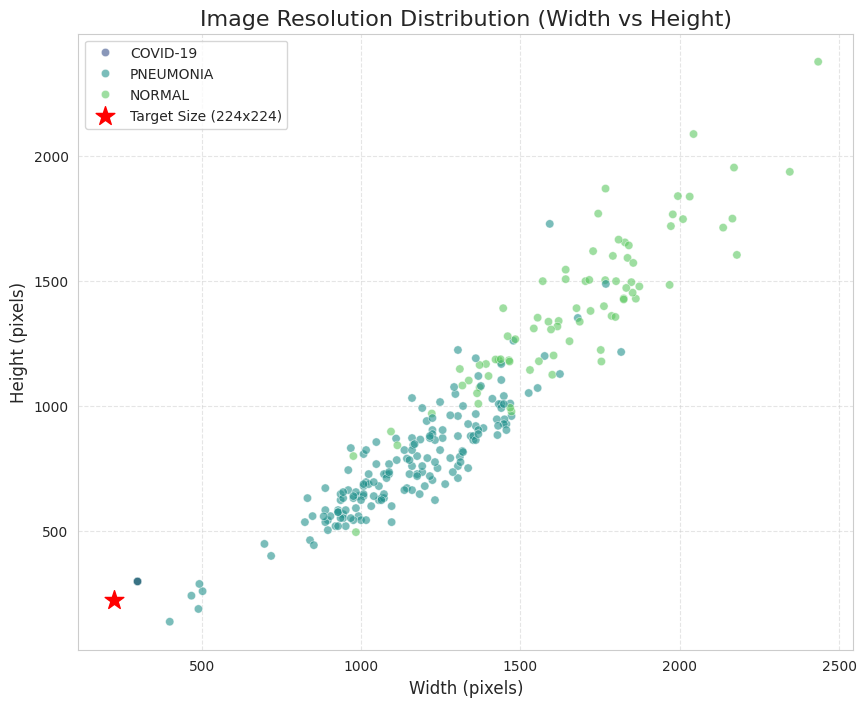

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import numpy as np

def analyze_dimensions(dataframe, sample_size=1000):
    """
    Generates an Scatter Plot (Width vs Height).
    Calculates and prints Mean Dimensions.
    Prints Frequency Tables for ranges.
    """
    print(f"Sampling {sample_size} images for dimensional analysis...")

    # Sampling
    if len(dataframe) > sample_size:
        sample_df = dataframe.sample(sample_size, random_state=42)
    else:
        sample_df = dataframe

    data = []

    # 2. Data Extraction
    for _, row in sample_df.iterrows():
        try:
            img = cv2.imread(row['filepath'])
            if img is not None:
                h, w, _ = img.shape
                data.append({
                    'label': row['label'],
                    'width': w,
                    'height': h
                })
        except Exception:
            pass # Skip corrupted

    stats_df = pd.DataFrame(data)


    # Average width and height
    avg_w = int(stats_df['width'].mean())
    avg_h = int(stats_df['height'].mean())
    print(f"Average Width: {avg_w}")
    print(f"Average Height: {avg_h}")


    # Frequency table
    ranges = [0, 500, 1000, 1500, 2000, 3000, 5000]
    labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-3000', '3000+']

    stats_df['Width_Range'] = pd.cut(stats_df['width'],
                                     bins=ranges, labels=labels)
    stats_df['Height_Range'] = pd.cut(stats_df['height'],
                                      bins=ranges, labels=labels)

    print("\n" + "="*40)
    print("FREQUENCY TABLE: WIDTH RANGES")
    print("="*40)
    print(pd.crosstab(stats_df['Width_Range'], stats_df['label']))

    print("\n" + "="*40)
    print("FREQUENCY TABLE: HEIGHT RANGES")
    print("="*40)
    print(pd.crosstab(stats_df['Height_Range'], stats_df['label']))



    # Scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=stats_df, x='width', y='height', hue='label',
                    alpha=0.6, palette='viridis')

    # Target marker
    plt.scatter([224], [224], color='red', s=200, marker='*',
                label='Target Size (224x224)')

    plt.title('Image Resolution Distribution (Width vs Height)', fontsize=16)
    plt.xlabel('Width (pixels)', fontsize=12)
    plt.ylabel('Height (pixels)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    return stats_df

# Execute
stats_data = analyze_dimensions(df)

### Analysis of Dimensional Results

The scatter plot and frequency tables show how image sizes are distributed and highlight an important detail in the visualization:

* **Square Aspect Ratio:** Most data points follow the pattern width = height, which shows that the majority of images are square.

* **Overplotting Effect:** The scatter plot seems to show many high-resolution images (above 1500 pixels) because those points are more spread out and easier to notice. However, the average values (width = 563, height = 475) indicate that most images are smaller. This happens because many low-resolution images overlap in the lower-left area of the plot (0–500 range), forming a dense cluster that looks small but actually contains many samples.

* **Class–Resolution Pattern:** The frequency tables show that image size varies by class:
    * **COVID-19 & NORMAL:** Most images (166 COVID and 520 NORMAL) are in the 0–500 pixel range.
    * **PNEUMONIA:** This class has many images in the 1001–1500 pixel range.

### Detailed Distribution: Resolution Bar Charts

The scatter plot shows how width and height are distributed, but many points overlap in the same area. As a result, lower resolution images are grouped in a small region of the plot, which can make the dataset appear to have a higher average resolution than it actually has.

Bar charts are used to display the exact number of images within specific resolution ranges.


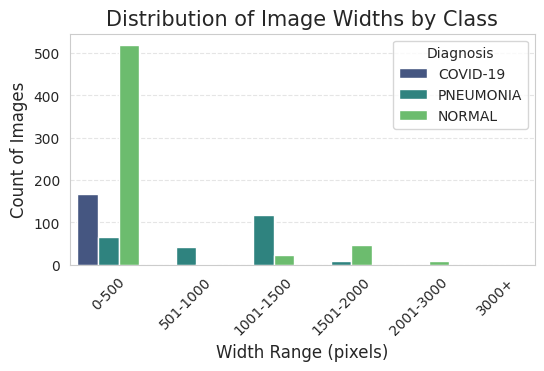

In [11]:
def plot_width_distribution(data):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=data, x='Width_Range', hue='label', palette='viridis')

    plt.title('Distribution of Image Widths by Class', fontsize=15)
    plt.xlabel('Width Range (pixels)', fontsize=12)
    plt.ylabel('Count of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Diagnosis')
    plt.show()

# Execute using the data from the first cell
plot_width_distribution(stats_data)

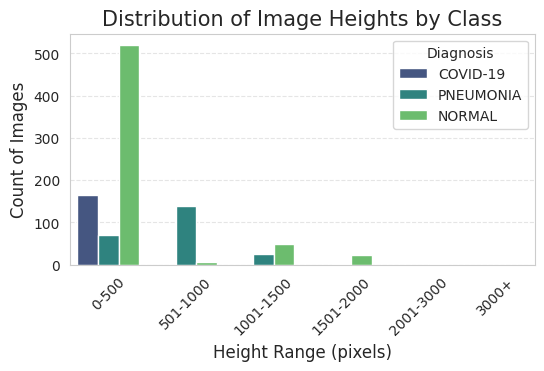

In [12]:
def plot_height_distribution(data):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=data, x='Height_Range', hue='label', palette='viridis')

    plt.title('Distribution of Image Heights by Class', fontsize=15)
    plt.xlabel('Height Range (pixels)', fontsize=12)
    plt.ylabel('Count of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Diagnosis')
    plt.show()

# Execute using the data from the first cell
plot_height_distribution(stats_data)

### Analysis of Dimensional Distribution

The bar charts show the image size distribution in more detail. Although some high-resolution images are present, most of the dataset consists of low-resolution samples:

* **0–500px Range:** Most `NORMAL` and `COVID-19` images are within the 0–500 pixel range. For these samples, resizing to 224x224 represents a moderate reduction and maintains relevant visual information.
* **Computational Efficiency:** Most images are relatively small, so using 224x224 as the target size is efficient and helps reduce GPU memory usage and training time.



## 6. Pre-processing

This section describes the preparation of the raw images prior to training. It includes image resizing, pixel normalization, and strategies to address class imbalance.

The original medical images vary in size, aspect ratio, and intensity range, so standardization is required before feeding them into the CNN.

The following subsections detail the input standardization steps and the three experimental approaches used to manage the class distribution.

### 6.1 Image Resizing & Global Configuration

**Objective:** Resize all images to a fixed size before training.

The selected input size is **224x224 pixels** because:

1. **Model Compatibility:** Architectures such as VGG16, ResNet, and DenseNet are commonly trained with 224x224 inputs.
2. **Resource Usage:** Smaller input dimensions reduce GPU memory consumption and training time compared to larger sizes such as 512x512.
3. **Feature Retention:** Detecting these conditions does not require extremely fine detail. The relevant patterns in chest X-rays are mostly large and diffuse, so they remain identifiable at 224x224 resolution.


**Implementation:**

The image dimensions and key hyperparameters are defined as global constants.

In [13]:
# Image Dimensions
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3) # Includes RGB channels


print(f"Global Configuration Set:")
print(f"- Target Image Size: {IMG_SIZE}")
print(f"- Input Shape: {IMG_SHAPE}")

Global Configuration Set:
- Target Image Size: (224, 224)
- Input Shape: (224, 224, 3)


#### Visual Verification of Resizing

Before applying resizing to the full dataset during training, a visual check is performed on a small sample of images.

The following code displays a grid with 5 random samples per class. This step allows verification that:

1. The aspect ratio is handled correctly and the lungs are not distorted.
2. The main anatomical structures are still visible after resizing.


Generating visual grid for target size: (224, 224)...


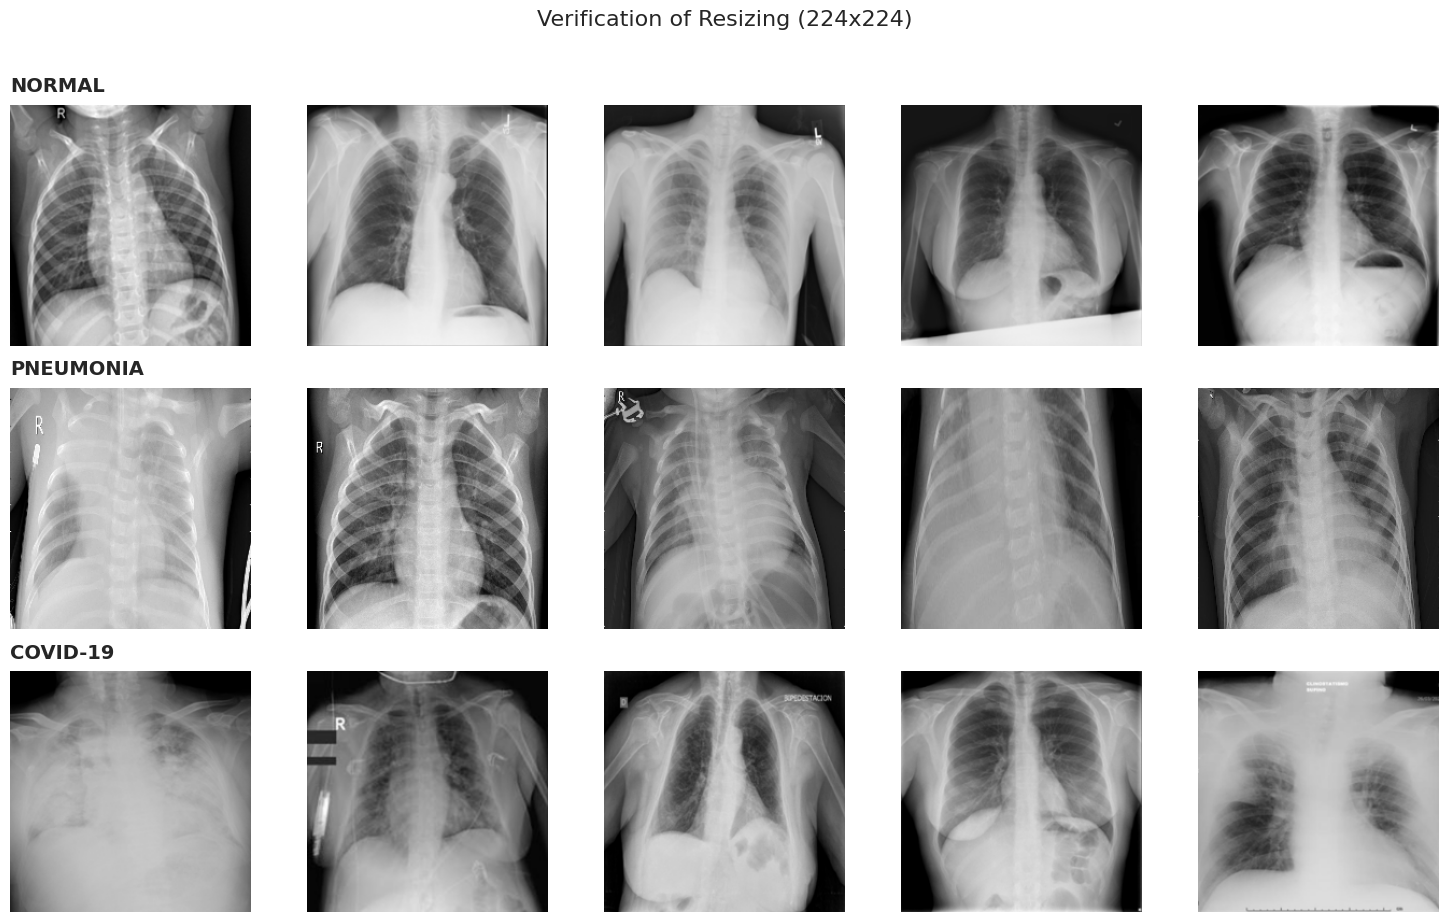

In [14]:
import cv2
import matplotlib.pyplot as plt

def visualize_resized_samples(dataframe, categories, target_size, samples_per_category=5):
    """
    Displays a grid of random images for each specified category after resizing them.

    Args:
        dataframe (pd.DataFrame): The master dataset containing file paths.
        categories (list): List of label names to visualize
        target_size (tuple): The target (width, height) for resizing.
        samples_per_category (int): Number of images to show per class.
    """

    # Calculate grid size: Rows = number of classes, Cols = samples per class
    n_rows = len(categories)
    n_cols = samples_per_category

    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    print(f"Generating visual grid for target size: {target_size}...")

    for i, category in enumerate(categories):
        # Filter the dataframe for the specific class
        class_df = dataframe[dataframe['label'] == category]

        # Take a random sample
        try:
            random_samples = class_df.sample(samples_per_category, random_state=SEED)
        except ValueError:
            random_samples = class_df # Take all if fewer than requested

        for j, (_, row) in enumerate(random_samples.iterrows()):
            img_path = row['filepath']

            # Read image using OpenCV
            img = cv2.imread(img_path)

            if img is not None:

                # RESIZE
                img = cv2.resize(img, target_size)

                # Convert from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine current subplot axis
                if n_rows > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]

                # Display image
                ax.imshow(img)
                ax.axis('off') # Hide axes ticks

                # Set title only on the first image of the row
                if j == 0:
                    ax.set_title(f"{category}", fontsize=14, fontweight='bold', pad=10, loc='left')
            else:
                print(f"Could not read image at {img_path}")

    plt.suptitle(f"Verification of Resizing ({target_size[0]}x{target_size[1]})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Define the order of categories to inspect
target_categories = ['NORMAL', 'PNEUMONIA', 'COVID-19']

# Execute the visualization function using the Global Constant IMG_SIZE
visualize_resized_samples(df, target_categories, IMG_SIZE, samples_per_category=5)

### Analysis of Resizing Results

The resized samples (224x224) are reviewed to evaluate how the transformation affects the images:

* **Geometric Changes:** Converting rectangular images to a square format causes a vertical elongation in some cases. However, the overall chest structure remains consistent, and no important areas are cut out.
* **Pattern Visibility:** The main pathological patterns in PNEUMONIA and COVID-19 images are still visible after resizing. The reduction in size does not remove the visual cues needed for classification.
* **Conclusion:** The distortion introduced by resizing is not significant and does not affect the usability of the images.



### 6.2 Pixel Normalization

**Objective:** Scale pixel intensity values to the range [0, 1].

**Justification:**

Raw input images contain pixel values in the range [0, 255]. Dividing these values by 255 converts them to a floating-point range of [0, 1]. This transformation maintains a smaller and consistent numerical scale.

The benefits are:
1. **Numerical Stability:** Keeping pixel values between 0 and 1 avoids extremely large numbers during training, which helps maintain stable calculations.  
2. **Training Efficiency:** Normalized values make the training process smoother and more consistent, without requiring adjustments for large input values.

**Verification Method:**

A pixel intensity histogram is generated to confirm that the transformation maps the original values from [0, 255] to [0, 1] while preserving the distribution of intensities in the images.


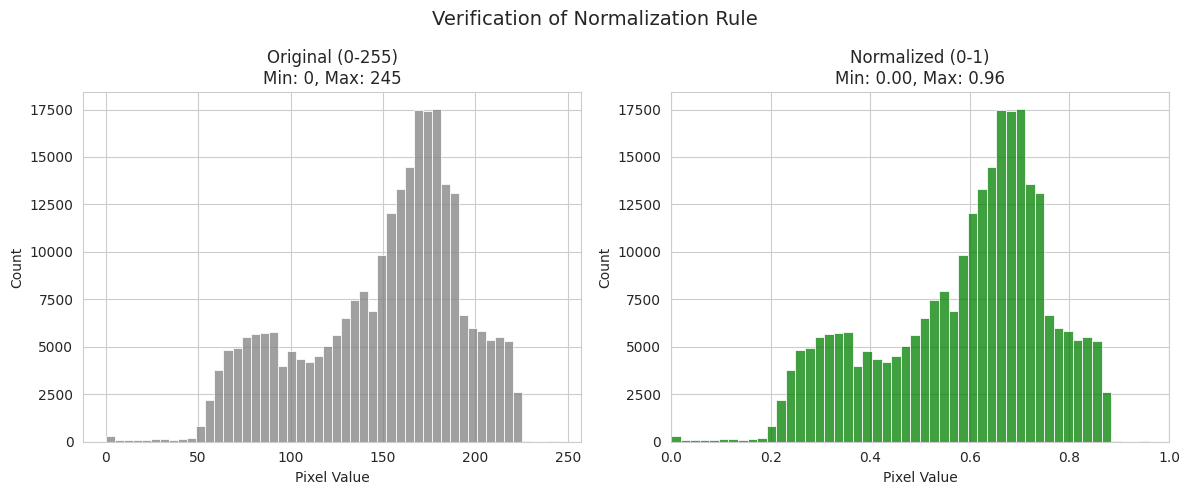

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def verify_normalization(dataframe):
    """
    Applies the normalization rule (pixel / 255) to a random sample
    and plots the histogram.
    """
    # Pick a random image
    sample = dataframe.sample(1, random_state=SEED).iloc[0]
    img = cv2.imread(sample['filepath'])

    if img is None:
        print("Error: Could not read image.")
        return

    # Apply the normalization
    img_norm = img.astype('float32') / 255.0

    # Plot Comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram BEFORE
    sns.histplot(img.ravel(), bins=50, color='gray', ax=axes[0])
    axes[0].set_title(f'Original (0-255)\nMin: {img.min()}, Max: {img.max()}')
    axes[0].set_xlabel('Pixel Value')

    # Histogram AFTER
    sns.histplot(img_norm.ravel(), bins=50, color='green', ax=axes[1])
    axes[1].set_title(f'Normalized (0-1)\nMin: {img_norm.min():.2f}, Max: {img_norm.max():.2f}')
    axes[1].set_xlabel('Pixel Value')
    axes[1].set_xlim(0, 1.0)

    plt.suptitle(f"Verification of Normalization Rule", fontsize=14)
    plt.tight_layout()
    plt.show()

# Execute function
verify_normalization(df)

### Analysis of Normalization Results

The generated histograms show the effect of the pixel scaling process. The axes can be interpreted as follows:

* **X-Axis (Pixel Intensity):** Represents the brightness level of the pixels.
    * **Left side (0):** Absolute black .
    * **Right side (255 or 1.0):** Absolute white.  
* **Y-Axis (Count):** Represents the number of pixels at each intensity level.
    * Peaks indicate the most common pixel values in the image.

**Observations:**

1. **Range Shift:** Pixel values have been scaled from the original integer range [0, 255] to the float range [0.0, 1.0]. The maximum value in the normalized plot corresponds proportionally to the original maximum.  
2. **Information Preservation:** The overall distribution shape remains the same after normalization. Peaks and valleys are unchanged, meaning relative contrast and anatomical details are preserved.



### 6.3 Handling Class Imbalance  

Exploratory Data Analysis (EDA) shows that the dataset is not evenly distributed across classes. The `NORMAL` class contains approximately 11,775 images (around 56% of the dataset), while `PNEUMONIA` includes about 5,618 images and `COVID-19` approximately 3,616 images (around 17%). This indicates that the pathological classes are underrepresented compared to the normal class.

Since the class distribution is uneven, imbalance handling strategies are incorporated before model training. Without adjustment, the training process would be influenced by the higher number of samples in the majority class. To evaluate different correction mechanisms under the same conditions, a comparative experimental setup is defined.

Three approaches are implemented independently. The first approach applies undersampling to reduce the size of the majority class. The second approach uses class weighting, modifying the loss function so that minority classes contribute proportionally more during optimization. The third approach applies data augmentation to generate synthetic samples and obtain a 1:1:1 class distribution.

Each strategy is trained using the same baseline CNN architecture to maintain consistency.




### Strategy A: Undersampling

An undersampling is applied to reduce the bias introduced by the large number of `NORMAL` images.

The `NORMAL` class is randomly downsampled to match the number of samples in the `PNEUMONIA` class (5,618).

This adjustment reduces the gap between the healthy and disease classes. By limiting the excess of normal samples.


In [16]:
from sklearn.utils import shuffle

def undersampling(dataframe, target_class='NORMAL', target_count=5618):
    """
    Creates a new dataframe where the specified majority class is downsampled
    to a specific number.

    Args:
        dataframe: The original dataset.
        target_class (str): The label of the class to be reduced.
        target_count (int): The number of samples to keep for the target class.

    Returns:
        A new dataframe with the reduced class.
    """
    # Isolate the class to be reduced
    df_target = dataframe[dataframe['label'] == target_class]

    # Isolate the other classes
    df_others = dataframe[dataframe['label'] != target_class]

    # Randomly sample the target class
    if len(df_target) > target_count:
        df_target_downsampled = df_target.sample(n=target_count, random_state=SEED)
    else:
        df_target_downsampled = df_target

    # Concatenate and Shuffle
    df_result = pd.concat([df_target_downsampled, df_others])
    df_result = shuffle(df_result, random_state=SEED).reset_index(drop=True)

    return df_result

# Execute

print("Applying Undersampling...")
df_undersampling = undersampling(df, target_class='NORMAL', target_count=5618)

# Verification
print("\n" + "="*40)
print("Original Dataset distribution:")
print(df['label'].value_counts())
print("-" * 40)
print("Undersampled Dataset distribution:")
print(df_undersampling['label'].value_counts())
print("="*40)

Applying Undersampling...

Original Dataset distribution:
label
NORMAL       11775
PNEUMONIA     5618
COVID-19      3616
Name: count, dtype: int64
----------------------------------------
Undersampled Dataset distribution:
label
NORMAL       5618
PNEUMONIA    5618
COVID-19     3616
Name: count, dtype: int64


### Analysis of Undersampling Results

The execution of the moderate undersampling strategy resulted in the experimental dataset (`df_undersampling`) having the following distribution:

* **NORMAL:** ~5,618 samples (reduced from ~11,700)  
* **PNEUMONIA:** ~5,618 samples (unchanged)  
* **COVID-19:** ~3,616 samples (unchanged)  

By aligning the `NORMAL` class with `PNEUMONIA`, the excess of healthy images is reduced. This limits the dominance of the majority class during training and allows a more balanced comparison between healthy and pathological cases. `PNEUMONIA` and `COVID-19` samples are preserved.

An alternative approach would have been to enforce a 1:1:1 balance by reducing every class to ~3,616 samples. This option was not applied because it would require removing approximately 2,000 pneumonia images. Pathological data is limited and important for learning disease patterns, so it is retained. The resulting imbalance (1.5:1) is moderate.




### 6.3 Strategy B: Class Weighting

Class weighting is applied to handle class imbalance while keeping the original dataset of 21,009 images unchanged.

The dataset distribution is not modified. Instead, different weights are assigned to each class in the loss function during training. Errors in minority classes receive a higher penalty than errors in majority classes. This makes the model pay more attention to underrepresented classes, such as COVID-19.

Weights are assigned using the formula:

**W_j = N_total / (N_classes × N_j)**

Where:
- N_total is the total number of samples.
- N_classes is the number of classes (3).
- N_j is the number of samples in class j.

**Implementation Details (class_weight='balanced'):**

To implement this weighting scheme, the `compute_class_weight` function from Scikit-Learn is used with the parameter `class_weight='balanced'`.

Three configuration options were considered when assigning class weights: None, a manual dictionary, and 'balanced'. The `'balanced'` option was selected because it calculates the weights based on how many samples each class has. In this way, classes with fewer images receive higher weights, and classes with more images receive lower weights, without requiring manual adjustments.


The default option (None) leaves all classes with equal weight, which would keep the original imbalance unchanged during training.

A manual dictionary (for example, {0:1, 1:50}) allows custom weights, but it depends on subjective choices and it doesn´t reflect the real class proportions in the dataset.




In [17]:
from sklearn.utils import class_weight
import numpy as np

def calculate_class_weights(dataframe):
    """
    Computes the weights for each class to balance the loss function.
    """
    # Extract the label column
    labels = dataframe['label']

    # Get unique classes(sorted alphabetically)
    classes = np.unique(labels)

    # Compute weights using the balanced heuristic
    # This applies the formula: n_samples / (n_classes * n_samples_in_class)
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=labels
    )

    # Create a dictionary mapping Class Index -> Weight (model.fit() format)
    class_weight_dict = dict(enumerate(weights))

    return class_weight_dict, classes

# Execute
print("Calculating Class Weights...")

weights_dict, class_names = calculate_class_weights(df)

# Verification
print("\n" + "="*60)
print(f"Total Samples: {len(df)}")
print(f"Classes: {class_names}")
print("-" * 60)
print("Computed Weights:")
for i, label in enumerate(class_names):
    count = len(df[df['label'] == label])
    weight = weights_dict[i]
    print(f"Class '{label}' ({count} images): \tWeight = {weight:.4f}")
print("="*60)

Calculating Class Weights...

Total Samples: 21009
Classes: ['COVID-19' 'NORMAL' 'PNEUMONIA']
------------------------------------------------------------
Computed Weights:
Class 'COVID-19' (3616 images): 	Weight = 1.9367
Class 'NORMAL' (11775 images): 	Weight = 0.5947
Class 'PNEUMONIA' (5618 images): 	Weight = 1.2465


### Analysis of Class Weighting Results

The calculated weights show how the `'balanced'` option adjusts for class imbalance. Classes with fewer samples receive higher weights, while classes with more samples receive lower weights:

* **COVID-19 (Class 0):** Minority class (3,616 images), weight = 1.94  
* **NORMAL (Class 1):** Majority class (11,775 images), weight = 0.59  
* **PNEUMONIA (Class 2):** Intermediate class (5,618 images), weight = 1.25  

During training, these weights are applied in the loss function.


**Index Mapping:**  
The weight dictionary uses numeric indices (`0, 1, 2`) instead of the class names because the model represents class labels as integers. The assignment of indices follows alphabetical order.



### 6.4 Strategy C: Offline Data Augmentation  

The objective of this strategy is to balance the dataset by artificially generating additional images for the minority classes (`COVID-19` and `PNEUMONIA`) until they reach the same number of samples as the majority class (`NORMAL`, with 11,775 images). This aims to mitigate class imbalance prior to model training and reduce potential bias toward the dominant class.

Unlike online augmentation, where transformations are applied dynamically during training within the neural network pipeline, this approach follows an offline procedure. In this case, new images are generated, transformed, and physically stored on disk in a separate directory (`dataset_augmented`). As a result, the dataset is balanced, ensuring a 1:1:1 class distribution before training begins. This setup also allows direct visual inspection and quality control of the generated synthetic images.

Given that the data consists of medical images, augmentation operations are constrained to preserve anatomical validity. Controlled random zoom (approximately 10–15%) is applied to simulate variations in patient positioning or acquisition distance. In addition, moderate adjustments to brightness and contrast are introduced to account for potential differences in X-ray machine calibration. Operations such as horizontal or vertical flips and pronounced rotations are not applied, since they can alter anatomical consistency, for example by modifying the position of the heart.

Testing augmentation on a random COVID-19 image...


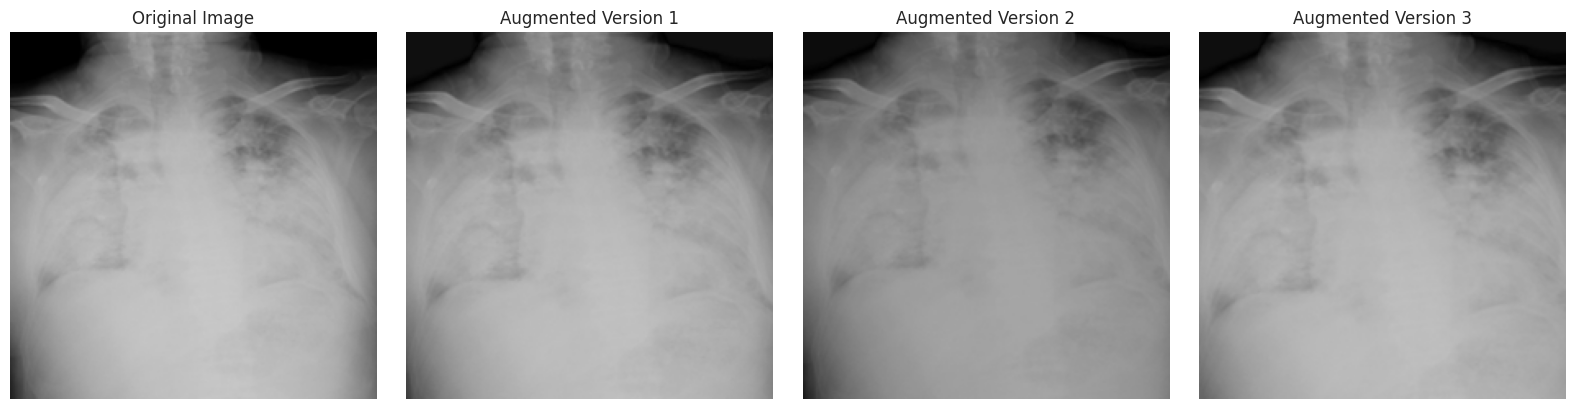

In [18]:
import cv2
import random
import matplotlib.pyplot as plt

def augment_image_cv2(image_path, target_size=IMG_SIZE):
    """
    Reads an image from disk, applies augmentations
    (Zoom and Brightness/Contrast), and returns the transformed image.
    """
    # Read image
    img = cv2.imread(image_path)

    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Random Brightness & Contrast
    # Alpha controls contrast (1.0 is normal). Range: 0.85 to 1.15
    # Beta controls brightness (0 is normal). Range: -15 to 15
    alpha = random.uniform(0.85, 1.15) #float
    beta = random.randint(-15, 15) #int
    img_aug = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # Random Zoom
    scale = random.uniform(0.85, 0.95)
    h, w = img_aug.shape[:2] #only first two dimensions

    new_h, new_w = int(h * scale), int(w * scale)

    # Calculate random starting point for the crop
    top = random.randint(0, h - new_h)
    left = random.randint(0, w - new_w)

    # Apply crop
    img_aug = img_aug[top:top+new_h, left:left+new_w]

    # Resize to standardize dimensions (224x224)
    img_aug = cv2.resize(img_aug, target_size)

    return img_aug

# Test
print("Testing augmentation on a random COVID-19 image...")

# Pick a random COVID image from the original DataFrame
test_row = df[df['label'] == 'COVID-19'].sample(1, random_state=SEED).iloc[0]
test_img_path = test_row['filepath']

# Generate 3 augmented versions of the same image
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
img_orig = cv2.imread(test_img_path)
img_orig = cv2.cvtColor(cv2.resize(img_orig, IMG_SIZE), cv2.COLOR_BGR2RGB)
axes[0].imshow(img_orig)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Augmented Versions
for i in range(1, 4):
    # Apply function
    img_aug = augment_image_cv2(test_img_path, target_size=IMG_SIZE)
    # Convert BGR to RGB
    img_aug_rgb = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img_aug_rgb)
    axes[i].set_title(f"Augmented Version {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Analysis of Augmentation Visualization  

The visualization step is used to verify that the selected augmentation operations (random zoom and brightness/contrast adjustments) are being applied as intended. The augmented images appear visually similar to the original sample, which is expected in the context of medical imaging, where transformations must preserve anatomical structure and pathological information.

From the inspection, the random zoom operation results in slight cropping of the dark borders present in chest X-rays. Anatomical structures such as the clavicles are closer to the image boundaries, reflecting the intended spatial variation. The pathological patterns within the lungs remain intact, with no visible distortion or structural alteration.

Although these modifications may appear minimal to a human observer, they are sufficient for training purposes. Small spatial or intensity variations help the model focus on general patterns associated with the condition instead of relying on fixed pixel arrangements from specific images. For this reason, only controlled and realistic adjustments are introduced.

This visualization serves as a validation of the augmentation logic using a single randomly selected sample. The transformations have not yet been applied to the full dataset.

### Data Augmentation Implementation  

The implementation stores the original image file paths in memory and manages them through a Python dictionary structure. This allows the system to reference existing images efficiently during the augmentation process. For each minority class, the algorithm calculates the difference between its current number of samples and the target value of 11,775 images. Based on this computed deficit, new synthetic samples are generated using the `augment_image_cv2` function, which applies controlled transformations such as zoom and brightness/contrast adjustments to existing images.

The generated images are saved to the `dataset_augmented_generated` directory. A unified DataFrame (`df_augmented`) is then constructed, containing the paths of the 21,009 original images and the 14,316 synthetic images, resulting in a total of 35,325 entries.

The final output is a balanced dataset represented in memory through a single consolidated DataFrame, ready for subsequent processing within the training pipeline.

In [19]:
import os
import cv2
import uuid
import pandas as pd
from tqdm.notebook import tqdm
import random

# Directory to save synthetic images
AUGMENTED_GENERATED_DIR = "dataset_augmented_generated"
TARGET_SAMPLES = 11775  # The number of images in the majority class

# Create directories if they do not exist
for label in ['COVID-19', 'PNEUMONIA']:
    os.makedirs(os.path.join(AUGMENTED_GENERATED_DIR, label), exist_ok=True)

# Start with a copy of the original dataset records
new_data = df.to_dict('records')

print(f"Starting data augmentation, creating directory '{AUGMENTED_GENERATED_DIR}' for synthetic images...")

# GENERATE SYNTHETIC IMAGES (AUGMENTATION)
print("\nGenerating synthetic images to balance the classes...")

# Calculate how many images are missing per class
counts = df['label'].value_counts()

for label in ['COVID-19', 'PNEUMONIA']:
    current_count = counts[label]
    deficit = TARGET_SAMPLES - current_count

    if deficit > 0:
        print(f"-> Generating {deficit} new images for {label}...")

        # Get a list of the original paths for this class to use as templates
        class_original_paths = df[df['label'] == label]['filepath'].tolist()

        for _ in tqdm(range(deficit), desc=f"Augmenting {label}"):
            # Randomly pick an original image from this class
            random_original = random.choice(class_original_paths)

            # Apply the Zoom/Brightness function
            try:
                img_aug = augment_image_cv2(random_original, target_size=IMG_SIZE)

                # Create a unique filename with uuid and define the destination path
                unique_filename = f"aug_{uuid.uuid4().hex[:8]}.jpg"
                dst_path = os.path.join(AUGMENTED_GENERATED_DIR, label, unique_filename)

                # Save physically to the disk
                cv2.imwrite(dst_path, img_aug)

                # Add only the NEW synthetic image to the record
                new_data.append({'filepath': dst_path, 'label': label})

            except Exception as e:
                print(f"Error augmenting image: {e}")

# Create new DataFrame
print("\nCreating the new DataFrame...")
df_augmented = pd.DataFrame(new_data)

# Shuffle
df_augmented = df_augmented.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("\n" + "="*50)
print("Augmentation completed")
print("="*50)
print("Distribution of the new DataFrame (df_augmented):")
print(df_augmented['label'].value_counts())
print("="*50)

Starting data augmentation, creating directory 'dataset_augmented_generated' for synthetic images...

Generating synthetic images to balance the classes...
-> Generating 8159 new images for COVID-19...


Augmenting COVID-19:   0%|          | 0/8159 [00:00<?, ?it/s]

-> Generating 6157 new images for PNEUMONIA...


Augmenting PNEUMONIA:   0%|          | 0/6157 [00:00<?, ?it/s]


Creating the new DataFrame...

Augmentation completed
Distribution of the new DataFrame (df_augmented):
label
PNEUMONIA    11775
COVID-19     11775
NORMAL       11775
Name: count, dtype: int64


### Analysis of Augmentation Results  

The data augmentation procedure was completed, generating the required number of synthetic images to address the initial class imbalance.

After augmentation, each class (`NORMAL`, `COVID-19`, and `PNEUMONIA`) contains 11,775 samples, resulting in a total of 35,325 images in the consolidated dataset. This produces a balanced 1:1:1 class distribution prior to model training.

A new directory named `dataset_augmented` was created to store both the original and the generated images. The data is organized into class-specific subfolders.

With the augmented images physically stored on disk, the dataset is ready to be loaded for training the CNN.

### 7. Setup and Utilities  

Before defining the CNN architecture and running the experiments, common data handling operations are grouped into reusable functions. This avoids repeating the same code across different imbalance strategies (class weighting, undersampling, and data augmentation) and keeps configuration parameters consistent.

This section centralizes directory preparation for compatibility with `image_dataset_from_directory`, dataset loading with a fixed 80/20 train–validation split, and input pipeline optimization using TensorFlow utilities such as `prefetch` and `AUTOTUNE`. Evaluation and plotting functions are also defined here to ensure that all models are measured using the same metrics and visualization settings.



### 7.1 Dataset Directory Orchestrator  

This function converts the image references stored in the DataFrame into a directory structure on disk compatible with TensorFlow data loaders.

Deep learning utilities such as `image_dataset_from_directory` expect images to be organized into subfolders named after their respective classes (`NORMAL`, `COVID-19`, `PNEUMONIA`). For this reason, the function creates a root directory and the corresponding class-specific subdirectories.

Each image is then copied from its original location into the appropriate class folder.

In [20]:
import os
import shutil
import pandas as pd
from tqdm.notebook import tqdm

def create_dataset_directory(dataframe: pd.DataFrame, output_dir: str) -> None:

    # If doesn't exist, create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directory '{output_dir}' created.")
    else:
        print(f"The directory '{output_dir}' already exists. Verifying content...")

    # Iterate through the DataFrame to organize files
    print(f"Organizing images into class-based folders in '{output_dir}'...")

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        src_path = row['filepath']  # Original path
        label = row['label']        # Original labels

        # Name of the file
        filename = os.path.basename(src_path)

        # Create class directory
        class_dir = os.path.join(output_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # New destination path
        dst_path = os.path.join(class_dir, filename)

        # Only copy the file if it doesn't already exist
        if not os.path.exists(dst_path):
            try:
                shutil.copy(src_path, dst_path)
            except Exception as e:
                print(f"Error copying {src_path}: {e}")

    print("\nDataset folder structure successfully created.")

### 7.2 Data Loading and Preparation  

In this step, the image dataset is loaded from disk and prepared for training and validation using TensorFlow’s `image_dataset_from_directory()` utility. This function reads images from a structured directory where each subfolder corresponds to a class label and returns a `tf.data.Dataset` object suitable for model training.

An automatic 80/20 split is applied to separate training and validation data. A fixed random seed ensures reproducibility, meaning the same images remain in the same subset across different experimental runs. During loading, all images are resized to (224, 224), converted to grayscale, grouped into batches of size 32, and shuffled in the training subset to improve generalization. The validation subset is not shuffled to maintain consistent evaluation.



In [21]:
import tensorflow as tf
from typing import Tuple

def load_and_prepare_datasets(
    directory: str,
    img_size: tuple = IMG_SIZE,
    batch_size: int = BATCH_SIZE,
    seed: int = SEED
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    print(f"Loading datasets from '{directory}'...")

    # Training Dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )

    # Validation Dataset
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )

    # Performance optimization
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, validation_dataset

### 7.3 Performance Visualization Utility  

This utility evaluates the trained model on the validation dataset and reports final loss and accuracy values.

It also plots training and validation accuracy and loss across epochs. These curves allow comparison between training and validation performance for each test.


In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

def evaluate_and_plot(
    model: tf.keras.Model,
    validation_dataset: tf.data.Dataset,
    history: tf.keras.callbacks.History
) -> None:

    # Model evaluation
    print("Evaluating model...")
    loss, accuracy = model.evaluate(validation_dataset, verbose=1)

    print(f'\nFinal Results:')
    print(f'Loss: {loss:.4f}')
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Training history plots
    plt.figure(figsize=(12, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

### 7.4 Performance metrics

The evaluation of a classification model requires multiple complementary metrics in order to understand it perfomance. The following metrics were selected:



*   **Accuracy**: Measures the proportion of correctly classified samples over the total number of samples. Is useful as a first general assessment of the model.
*   **Precision**: Measures the proportion of correctly predicted positive samples out of all predicted positive samples. It is important when the cost of false positives is high.
*   **Recall**: Measures the proportion of actual positive samples that were correctly identified by the model. A high recall ensures that most diseased cases are correctly identified.
*   **F1-Score**: Is the combine of Precision and Recall. It provides a balanced measure when both false positives and false negatives are important.
*   **Confusion Matrix**: Provides a detailed breakdown of predictions by showing the number of true positives, true negatives, false positives, and false negatives for each class.








In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_model_mosaic(model, dataset, class_names):

    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Model Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # performance metric values
    accuracy = report["accuracy"]
    precision = report["macro avg"]["precision"]
    recall = report["macro avg"]["recall"]
    f1 = report["macro avg"]["f1-score"]

    # Create mosaic layout
    fig = plt.figure(figsize=(14, 8))
    mosaic = """
    AABB
    CCDD
    """
    ax = fig.subplot_mosaic(mosaic)

    # Accuracy
    ax["A"].bar(["Accuracy"], [accuracy])
    ax["A"].set_ylim(0, 1)
    ax["A"].set_title("Accuracy")
    ax["A"].grid(True)

    # Precision
    ax["B"].bar(["Precision (Macro)"], [precision])
    ax["B"].set_ylim(0, 1)
    ax["B"].set_title("Precision")
    ax["B"].grid(True)

    # Recall
    ax["C"].bar(["Recall (Macro)"], [recall])
    ax["C"].set_ylim(0, 1)
    ax["C"].set_title("Recall")
    ax["C"].grid(True)

    # F1 Score
    ax["D"].bar(["F1 Score (Macro)"], [f1])
    ax["D"].set_ylim(0, 1)
    ax["D"].set_title("F1 Score")
    ax["D"].grid(True)

    # Confusion Matrix (overlay as new axis)
    fig2, ax_cm = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

## 8. CNN Architecture  

This **Convolutional Neural Network (CNN)** is designed to extract **features** from chest X-ray images and classify them into three categories: **Normal**, **COVID-19**, and **Pneumonia**. The model follows a standard from **feature extraction** to **classification**.

* **Input**: Chest X-ray images with a shape of **224 × 224 pixels**.

* **Rescaling Layer**: A **normalization** step is applied to rescale pixel values. This improves **training stability** and enables **faster convergence** during optimization.

* **Feature Extraction**:  
  The model uses **convolutional layers (Conv2D)** with a **3 × 3 kernel size**. The first layers include **32 filters** to capture basic patterns such as edges and textures, while deeper layers use **64 filters** to learn more **complex features**. These values are commonly used as a baseline in established CNNs to balance accuracy and computational efficiency.
  
  **Max Pooling (2 × 2)** is applied to reduce the **spatial dimensions**, allowing the network to focus on the most **relevant features** while reducing computational cost.

* **Regularization**:  
  A **Dropout layer (20%)** is included to reduce **overfitting** by randomly deactivating 20% of the neurons during training.  
  Instead of using **Flatten**, the model applies **Global Average Pooling**, which computes the **average of each feature map**. This significantly reduces the number of parameters and helps improve **generalization**.

* **Classification (Fully Connected Layers)**:  
  A **Dense hidden layer** combines the extracted features and learns **complex relationships** between them.  
  Finally, the output layer uses a **Softmax activation function** to produce a **probability distribution** across the three classes.

  ## 8.1 Design decisions
  The architecture of the Convolutional Neural Network (CNN) was defined using specific parameters established as a baseline for the training and evaluation phases. The following design choices were made to optimize feature extraction and classification:

    ### **Feature Extraction Layers**

    **Convolutional Layers:**  
    The initial layer uses 32 filters to capture fundamental features (such as edges and textures) from the X-ray images. The second layer increases the depth to 64 filters, allowing the model to learn more complex spatial patterns.

    **Activation Function (ReLU):**  
    The Rectified Linear Unit (ReLU) was selected to introduce non-linearity. It maps negative values to zero and maintains positive inputs, which helps mitigate the vanishing gradient problem and ensures computational efficiency during backpropagation.

    **Max Pooling:**  
    To reduce spatial dimensions typically 2x2 Max Pooling is a downsampling technique that allows the network to recognize key features regardless of their exact position within the image.


    ### **Classification Head**

    **Fully Connected (Dense) Layer:**  
    A dense layer with 32 neurons and ReLU activation used as a baseline for feature integration. This layer merges the features extracted by the convolutional base to prepare for final classification.

    **Output Layer (Softmax):**  
    For the final classification of the three target classes, a Softmax activation function was used. This converts the output into a probability distribution.





In [24]:
# Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Rescaling, BatchNormalization

def create_model(input_shape=(224, 224, 3), num_classes=3):

  # Defines a linear stack of layers where data flows in order from input to output.
  model = Sequential()

  # Normalization: Scales pixel values from [0, 255] to [0, 1]
  model.add(Rescaling(1./255, input_shape=input_shape))

  # First Convolutional Block: Extracts basic features using 32 filters.
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # MaxPooling: Reduces the spatial dimensions of the feature maps.
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Second Convolutional Block: Extracts basic features using 32 filters.
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # MaxPooling: Reduces the spatial dimensions of the feature maps.
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Third Convolutional Block: Learns more complex patterns
  model.add(Conv2D(64, (3, 3), activation='relu'))
  # MaxPooling: Further downsamples the data to focus on high-level features.
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Fourth Convolutional Block: Learns more complex pattern
  model.add(Conv2D(64, (3, 3), activation='relu'))
  # MaxPooling: Further downsamples the data to focus on high-level features.
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Dropout: Regularization strategy by deactivating some neurons from the CNN
  model.add(Dropout(0.2))

  model.add(GlobalAveragePooling2D())

  # Fully Connected Layer: Combines all extracted features to interpret the data.
  model.add(Dense(32, activation='relu'))

  # Dropout: Additional regularization before the final decision.
  model.add(Dropout(0.2))

  # Output Layer: Uses 'softmax' to provide a probability distribution for the 3 classes
  model.add(Dense(3, activation='softmax'))

  return model


## 8.2 Model Architecture
For the architecture the next table explains every layer with their input and outputs por the extraction of features phase and the classification phase.

**Note**:

The value `None` represents an undefined batch size.

`Formula` for size reduce:
Output = (N - F + 2P) / S + 1
* N: Input size
* F: Kernel size
* P: Padding
* S: Stride

  For this scenario stride (how much the filter shifts across the input image) and padding (adding extra pixel rows/columns around the borders of an input image) are considerated 1.

  Sharma, T. (2024, marzo 16). Understanding padding & strides in Convolutional Neural Networks (CNN) for effective image feature extraction. Medium. https://medium.com/@Tms43/understanding-padding-strides-in-convolutional-neural-networks-cnn-for-effective-image-feature-1b0756a52918



**First Layer (Rescaling)**  
* Output: (None, 224, 224, 3): Input images resized to 224×224 with 3 channels (RGB).  
* Function: Normalizes pixel values and standardizes image dimensions.
* Params: 0 no learnable parameters.  

**Second Layer (Conv2D)**  
* Output: (None, 222, 222, 32): 32 feature maps of size 222 × 222.  
* Function: Applies 32 filters (3×3 as the kernel size) to extract basic features such as edges and textures.  
* Params: 896 = (3 × 3 × 3) × 32 + 32.
    * 3 x 3: kernel size
    * 3: input channel (combination of the image in RGB)
    * 32: number of filters
    * 32: bias

**Third Layer (MaxPooling2D)**  
* Output: (None, 111, 111, 32)
* Function: Reduces spatial dimensions using 2 × 2 pooling, keeping the most relevant features (222/2). Same 32 feature maps from the previous layer.   
* Params: 0 since pooling layers has not learn paramters.

**Fourth Layer (Conv2D)**  
* Output: (None, 109, 109, 32): 32 feature maps of size 109 x 109 reduced by the previous layers.
* Function: Applies 32 filters (3×3) to learn more complex feature combinations.  
* Params: 9,248 = (3 × 3 × 32) × 32 + 32.  
  * 3 x 3: kernel size
  * 32: feature maps from the previous layers
  * 32: number of filters
  * 32: bias

**Fifth Layer (MaxPooling2D)**  
* Output: (None, 54, 54, 32)
* Function: Further reduces spatial dimensions to improve efficiency (109/2) rounded down.  
* Params: 0 since pooling layers has not learn paramters.

**Sixth Layer (Conv2D)**  
* Output: (None, 52, 52, 64): 64 feature maps of size 52 x 52.  
* Function: Increases filters to 64 to capture more complex and abstract patterns.  
* Params: 18,496 = (3 × 3 × 32) × 64 + 64.  
  * 3 x 3: kernel size
  * 32: feature maps from the previous layer
  * 64: number of filters
  * 64: bias

**Seventh Layer (MaxPooling2D)**  
* Output: (None, 26, 26, 64):  
* Function: Downsamples feature maps to reduce dimensionality (52/2).
* Params: 0 since pooling layers has not learn paramters.

**Eighth Layer (Conv2D)**  
* Output: (None, 24, 24, 64)  
* Function: Learns high-level and more abstract features from the images.  
* Params: 36,928 = (3 × 3 × 64) × 64 + 64.  
  * 3 x 3: kernel size
  * 64: feature maps from the previous layer
  * 64: number of filters
  * 64: bias

**Ninth Layer (MaxPooling2D)**  
* Output: (None, 12, 12, 64)  
* Function: Final spatial reduction before classification (24/2).  
* Params: 0 since pooling layers has not learn paramters.

**Tenth Layer (Dropout)**  
* Output: (None, 12, 12, 64)  
* Function: Randomly disables neurons during training to prevent overfitting.  
* Params: 0 since pooling layers has not learn paramters.

**Eleventh Layer (GlobalAveragePooling2D)**  
* Output: (None, 64)  
* Function: Reduces each feature map into a single value by averaging, lowering dimensionality (1 x 1).  
* Params: 0 since pooling layers has not learn paramters.

**Twelfth Layer (Dense)**  
* Output: (None, 32)  
* Function: Combines extracted features into a compact representation.  
* Params: 2,080 = (64 × 32) + 32.  

**Thirteenth Layer (Dropout)**  
* Output: (None, 32)  
* Function: Adds regularization to reduce overfitting before final classification.  
* Params: 0  

**Final Layer (Dense)**  
* Output: (None, 3)  
* Function: Produces probabilities for the three target classes using softmax.  
* Params: 99 = (32 × 3) + 3.  

In [25]:
# Call model function
model = create_model()
# Architecture of the CNN: layer, parameters and steps
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,747 (264.64 KB)

 Trainable params: 67,747 (264.64 KB)

 Non-trainable params: 0 (0.00 B)

## 8.3 Optimizer and Loss Function

For this project, the **Adam optimizer** and **sparse categorical cross-entropy loss function** were selected due to their suitability for multi-class image classification tasks.

Adam Optimizer is useful due to the combination of two main concepts:

*   **Momentum**: Used to accelerate the gradient descent process by incorporating an exponentially weighted moving average of past gradients. Allowing the algorithm to converge faster by reducing oscillations.
*   **RMSprop**: The learning rate is adjusted individually for each parameter. If a parameter has large gradients, RMSProp reduces its learning rate; if they are small, RMSProp increases it.

This concepts let the model to adjust more efficiently and effective to the training dataset, resulting in greater accuracy of the prediction than other optimization methods.

**Sparse categorical cross-entropy** was chosen as the loss function because this is a multi-class clasification problem with mutually exclusive classes (NORMAL, COVID-19, and PNEUMONIA). Because of the model uses a softmax activation function in the output layer and each image belong to exactly one class, this loss function works properly.

Compared to **categorical cross-entropy**, the sparse version is more memory-efficient because it does not require one-hot encoding of labels.





## 8.4 Training parameters

Using the **.fit()** function, several key parameters control the learning process:


*   **training data**: the input data of each test used to train the model.
*   **epochs**: the number of complete passes through the entire training dataset. In this case, 15 epochs.
*   **validation data**: A separate dataset used to evaluate the model after each epoch.
*   **class_weight**: A dictionary that assigns a weight to each class. Only used for the Weighted Test.










## 9. Experimental Phase:

This section executes three tests to evaluate the impact of different class balancing strategies on model performance.

All experiments follow the same workflow defined in Section 7 for directory preparation and dataset loading. The CNN architecture defined in Section 8 remains unchanged across trials to ensure that any performance differences are attributable only to the data balancing strategy.

The evaluated configurations are Class Weighting, undersampling and data augmentation.

## 9.1 Weighted Test  

In this test, the class weighting configuration is applied during model training. The dataset and CNN architecture remain unchanged, and the only modification is the inclusion of class weights in the loss function.

Training is executed using the same dataframe, split configuration, and hyperparameters defined previously.

In [26]:
# Organizing original images into a class-based folder structure compatible with Keras.
create_dataset_directory(dataframe=df, output_dir="dataset")

Directory 'dataset' created.
Organizing images into class-based folders in 'dataset'...


  0%|          | 0/21009 [00:00<?, ?it/s]


Dataset folder structure successfully created.


In [27]:
# Load into TensorFlow Datasets
# Loading images into TensorFlow Datasets and performing an 80/20 split for training and validation.
train_ds_weight, val_ds_weight = load_and_prepare_datasets(directory="dataset")

Loading datasets from 'dataset'...
Found 21009 files belonging to 3 classes.
Using 16808 files for training.
Found 21009 files belonging to 3 classes.
Using 4201 files for validation.


In [28]:
# Generates penalties to balance the model's learning process
print("\nCalculating weight of the classes...")
weights_dict, _ = calculate_class_weights(df)
print(f"Weights applied: {weights_dict}")


Calculating weight of the classes...
Weights applied: {0: np.float64(1.936670353982301), 1: np.float64(0.5947346072186837), 2: np.float64(1.2465290138839444)}


In [29]:
# Compiling the model with the Adam optimizer and Sparse Categorical Crossentropy loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Execute the training phase for 15 epochs
# Class weights are injected to adjust based on class importance
print("\nTraining...")
history = model.fit(
    train_ds_weight,
    epochs=15,
    validation_data=val_ds_weight,
    class_weight=weights_dict
)


Training...
Epoch 1/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 87s 145ms/step - accuracy: 0.4213 - loss: 1.0334 - val_accuracy: 0.7051 - val_loss: 0.6438
Epoch 2/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.7135 - loss: 0.5999 - val_accuracy: 0.7891 - val_loss: 0.4670
Epoch 3/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 73s 139ms/step - accuracy: 0.7847 - loss: 0.4562 - val_accuracy: 0.8343 - val_loss: 0.3961
Epoch 4/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 65s 124ms/step - accuracy: 0.8239 - loss: 0.3799 - val_accuracy: 0.7682 - val_loss: 0.5537
Epoch 5/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 88s 135ms/step - accuracy: 0.8413 - loss: 0.3417 - val_accuracy: 0.8272 - val_loss: 0.4073
Epoch 6/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 64s 122ms/step - accuracy: 0.8620 - loss: 0.2951 - val_accuracy: 0.8536 - val_loss: 0.3388
Epoch 7/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 71s 136ms/step - accuracy: 0.8759 - loss: 0.2707 - val_accuracy: 0.9005 - val_loss: 0.2538
Epoch 8/15
526/526 ━━━━━━━━━━━━━━━━━━━━ 72s 136ms/step - accuracy: 0.8

### Training Analysis  

Over the 15 training epochs, the model shows a consistent increase in training accuracy, reaching approximately 93% by the end of the process. This indicates that the network is fitting the training data under the weighted loss configuration.



### Evaluation

Evaluating model...
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.9263 - loss: 0.2004

Final Results:
Loss: 0.2016
Accuracy: 92.79%


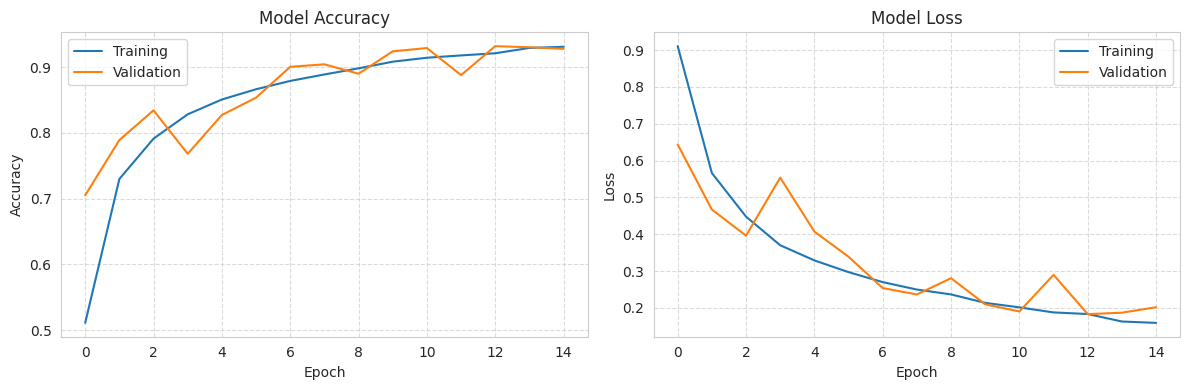

In [31]:
evaluate_and_plot(model, val_ds_weight, history)



The evaluation on the validation dataset results in a final accuracy of 92.79% and a loss of 0.0.2016.

The training curves show a consistent decrease in loss and a progressive increase in accuracy across epochs. The validation curves present observable fluctuations, including variations in both accuracy and loss.

These variations are consistent with the use of class weighting, where errors in minority classes have greater influence on the loss calculation. This configuration can produce more pronounced changes in validation metrics between epochs.

### Classification Report and Confusion Matrix  


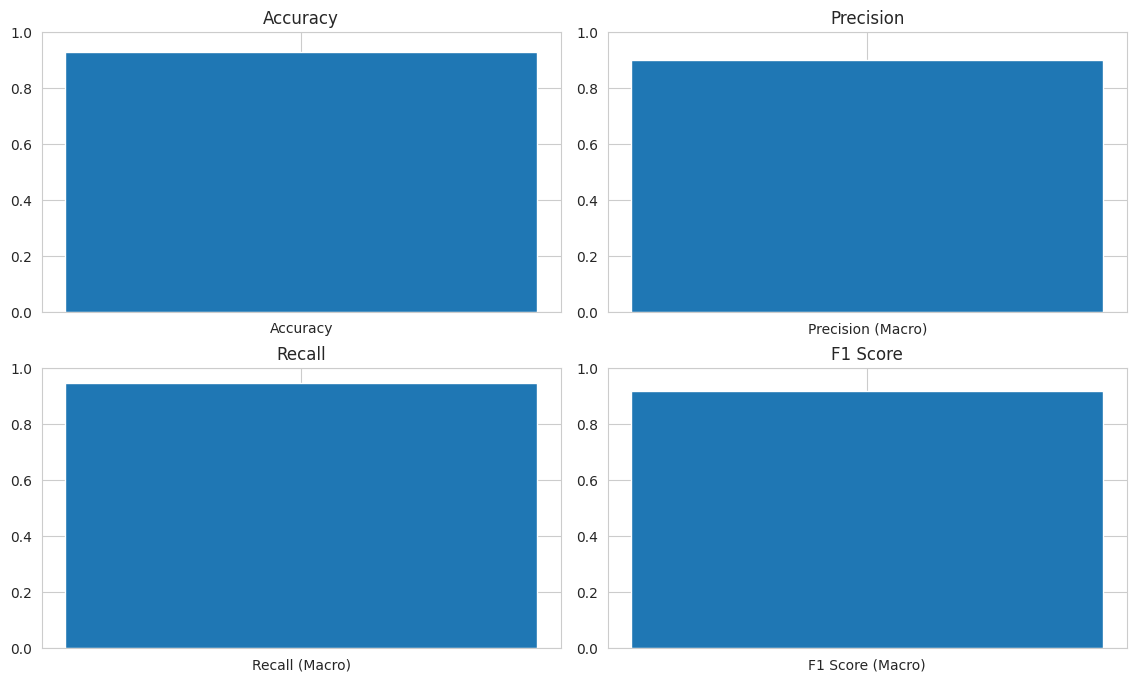

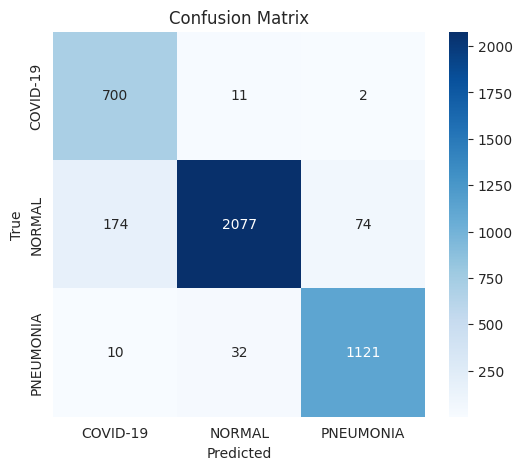


Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.79      0.98      0.88       713
      NORMAL       0.98      0.89      0.93      2325
   PNEUMONIA       0.94      0.96      0.95      1163

    accuracy                           0.93      4201
   macro avg       0.90      0.95      0.92      4201
weighted avg       0.94      0.93      0.93      4201



In [32]:
clases = ['COVID-19', 'NORMAL', 'PNEUMONIA']
plot_model_mosaic(model, val_ds_weight, clases)


The classification report and confusion matrix show the distribution of predictions across classes under the class weighting configuration.

For `COVID-19` and `PNEUMONIA`, the model achieves a recall of 0.98 and 0.96. In the case of COVID-19, 700 out of 713 actual cases are correctly identified, with 13 false negatives. This indicates a low rate of missed cases for the minority classes.

At the same time, the number of false positives increases. A total of 174 `NORMAL` images are classified as `COVID-19`, which reduces COVID-19 precision to 0.79 and decreases `NORMAL` recall to 0.89.

These results indicate that the class weighting strategy increases recall for minority classes while reducing precision for the majority class.

### 9.1 Conclusion: Weighted Test   

The class weighting strategy achieved an overall accuracy of approximately 93%. Training curves show stable convergence, while validation curves present noticeable variability across epochs, reflecting sensitivity to the weighted loss configuration.

Early experiments limited to 10 epochs produced more stable validation curves and similar overall accuracy, but COVID-19 recall remained at 0.83. Extending training to 15 epochs increased recall for the minority classes, reaching 0.98 for `COVID-19` and 0.96 for `PNEUMONIA`. This reduced the number of false negatives compared to the shorter training configuration.

The increase in recall was accompanied by a reduction in precision. In particular, 174 `NORMAL` samples were misclassified as `COVID-19`, lowering COVID-19 precision to 0.79.  

Overall, the weighted configuration shifts the model toward higher sensitivity for minority classes, with a corresponding increase in false positives for the majority class.

## 9.2 Undersampling Test

This second strategy addresses class imbalance by physically reducing the number of samples in the majority class. Specifically, the `NORMAL` category is downsampled to match the frequency of the `PNEUMONIA` class (5,618 images), resulting in a more balanced dataset prior to training.



In [33]:
# Applies the undersampling function to the majority class (NORMAL)
df_under = undersampling(
    dataframe=df,
    target_class='NORMAL',
    target_count=5618
)

print("Undersampled Dataset distribution:")
print(df_under['label'].value_counts())

Undersampled Dataset distribution:
label
NORMAL       5618
PNEUMONIA    5618
COVID-19     3616
Name: count, dtype: int64


In [34]:
# Organizing directories in dataset structure
create_dataset_directory(dataframe=df_under, output_dir="dataset_under")

Directory 'dataset_under' created.
Organizing images into class-based folders in 'dataset_under'...


  0%|          | 0/14852 [00:00<?, ?it/s]


Dataset folder structure successfully created.


In [35]:
# Load into TensorFlow Datasets
train_dataset_under, validation_dataset_under = load_and_prepare_datasets(directory="dataset_under")

Loading datasets from 'dataset_under'...
Found 14852 files belonging to 3 classes.
Using 11882 files for training.
Found 14852 files belonging to 3 classes.
Using 2970 files for validation.


In [36]:
# Instantiates a new model and compiles it
model_under = create_model()
model_under.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# Trains the model for 15 epochs
# class_weight is no longer used since the data is physically balanced
history_under = model_under.fit(
    train_dataset_under,
    epochs=15,
    validation_data=validation_dataset_under
)

Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - accuracy: 0.4660 - loss: 1.0085 - val_accuracy: 0.6811 - val_loss: 0.7688
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 46s 125ms/step - accuracy: 0.6900 - loss: 0.6836 - val_accuracy: 0.7478 - val_loss: 0.5553
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - accuracy: 0.7639 - loss: 0.5476 - val_accuracy: 0.8067 - val_loss: 0.4756
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.8110 - loss: 0.4599 - val_accuracy: 0.8354 - val_loss: 0.3924
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 82s 118ms/step - accuracy: 0.8356 - loss: 0.4021 - val_accuracy: 0.8909 - val_loss: 0.2900
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.8565 - loss: 0.3627 - val_accuracy: 0.8593 - val_loss: 0.3472
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.8671 - loss: 0.3421 - val_accuracy: 0.8987 - val_loss: 0.2694
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 74s 127ms/step - accuracy: 0.8829 - loss: 0

### Training Analysis  

The training logs for the undersampled dataset show a stable learning progression compared to the previous experiment.

Training accuracy increases from approximately 46% in the initial epoch and gradually converges. By epoch 15, both training and validation accuracy stabilize around 93%. Validation loss decreases consistently from approximately 0.77 to 0.19, without abrupt fluctuations between epochs.

The absence of pronounced variability in the validation curves indicates smoother optimization behavior.

### Evaluation


Evaluating model...
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.9296 - loss: 0.1807

Final Results:
Loss: 0.1883
Accuracy: 92.63%


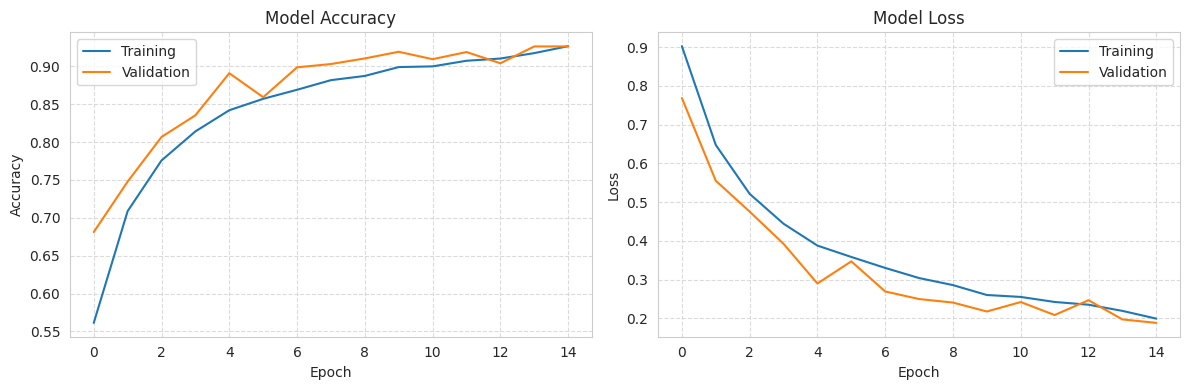

In [38]:
evaluate_and_plot(model_under, validation_dataset_under, history_under)

Evaluation on the dataset results in a final accuracy of 92.63% and a loss of 0.1883.

The learning curves show close alignment between training and validation metrics by the final epoch. Accuracy for both subsets stabilizes around 0.93, and loss values converge near 0.18–0.21. This pattern indicates consistent behavior between training and validation data.

Training curves decrease smoothly across epochs, without abrupt changes. Validation metrics present minor fluctuations, including a temporary variation around epoch 5, after which the trend returns to a gradual stabilization.

Overall, the undersampling configuration produces stable training dynamics with closely matched training and validation performance.

### Classification Report and Confusion Matrix  


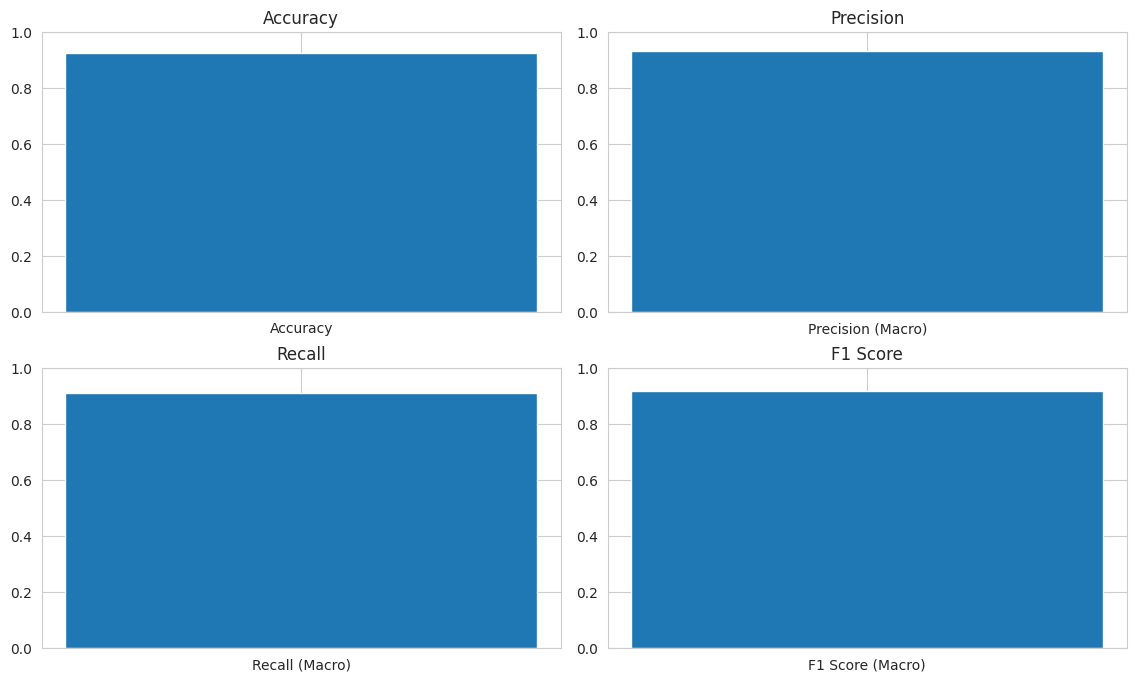

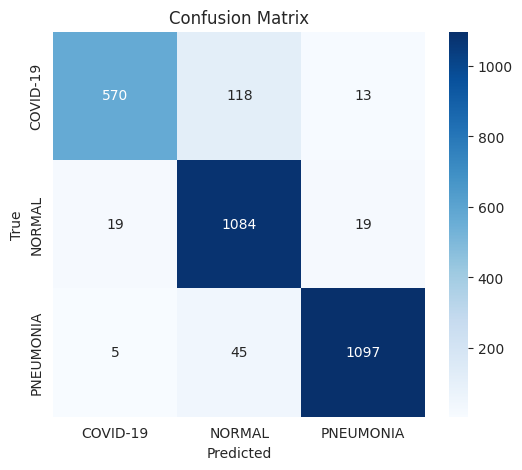


Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.81      0.88       701
      NORMAL       0.87      0.97      0.92      1122
   PNEUMONIA       0.97      0.96      0.96      1147

    accuracy                           0.93      2970
   macro avg       0.93      0.91      0.92      2970
weighted avg       0.93      0.93      0.93      2970



In [39]:
clases = ['COVID-19', 'NORMAL', 'PNEUMONIA']
plot_model_mosaic(model_under, validation_dataset_under, clases)

### Classification Report and Confusion Matrix Analysis  

The classification report and confusion matrix reflect a different prediction under the undersampling configuration. The model achieves an overall accuracy of 93%, with changes in the balance between precision and recall compared to the weighted approach.

COVID-19 precision increases to 0.96, and `NORMAL` recall reaches 0.97, indicating a reduction in false positives for both classes. At the same time, COVID-19 recall decreases to 0.81. The confusion matrix shows that 118 actual COVID-19 cases are misclassified as `NORMAL`, increasing the number of false negatives relative to the previous experiment.

These results indicate that undersampling improves precision for the minority class while reducing its recall.

### 9.2 Conclusion: Undersampling Test   

The undersampling strategy achieves an overall accuracy of 93% with stable training dynamics. Training and validation curves converge closely by the final epochs, and no pronounced instability is observed.

Precision for `COVID-19` increases to 0.96 and `NORMAL` recall reaches 0.97, indicating a reduction in false positives compared to the weighted configuration. However, COVID-19 recall decreases to 0.81, meaning that 20% of positive cases are not identified. The confusion matrix shows 118 COVID-19 samples misclassified as `NORMAL`.


## 9.3 Data Augmentation Test  

This third strategy evaluates **Data Augmentation** to address class imbalance by increasing the representation of minority classes through synthetic variations.

Transformationes like zoom or brightness are applied to `COVID-19` and `PNEUMONIA` images to expand their sample size and match the `NORMAL` class. The objective is to train the model on a balanced dataset without reducing the number of original samples.

In [40]:
# Organizing directories in dataset structure
create_dataset_directory(dataframe=df_augmented, output_dir="dataset_augmented_final")

Directory 'dataset_augmented_final' created.
Organizing images into class-based folders in 'dataset_augmented_final'...


  0%|          | 0/35325 [00:00<?, ?it/s]


Dataset folder structure successfully created.


In [41]:
# Load into TensorFlow Datasets
train_dataset_aug, validation_dataset_aug = load_and_prepare_datasets(directory="dataset_augmented_final")

Loading datasets from 'dataset_augmented_final'...
Found 35325 files belonging to 3 classes.
Using 28260 files for training.
Found 35325 files belonging to 3 classes.
Using 7065 files for validation.


In [42]:
# Instantiates and compiles a new model
model_aug = create_model()

model_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Trains the model for 15 epochs
history_aug = model_aug.fit(
    train_dataset_aug,
    epochs=15,
    validation_data=validation_dataset_aug
)

Epoch 1/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 99s 105ms/step - accuracy: 0.5400 - loss: 0.9198 - val_accuracy: 0.7349 - val_loss: 0.6136
Epoch 2/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 129s 94ms/step - accuracy: 0.7548 - loss: 0.5704 - val_accuracy: 0.8120 - val_loss: 0.4424
Epoch 3/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.8165 - loss: 0.4393 - val_accuracy: 0.8562 - val_loss: 0.3717
Epoch 4/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 74s 83ms/step - accuracy: 0.8644 - loss: 0.3467 - val_accuracy: 0.9045 - val_loss: 0.2530
Epoch 5/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 75s 84ms/step - accuracy: 0.8911 - loss: 0.2860 - val_accuracy: 0.9009 - val_loss: 0.2559
Epoch 6/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 101s 106ms/step - accuracy: 0.9077 - loss: 0.2489 - val_accuracy: 0.9240 - val_loss: 0.1952
Epoch 7/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 101s 114ms/step - accuracy: 0.9217 - loss: 0.2130 - val_accuracy: 0.9132 - val_loss: 0.2184
Epoch 8/15
884/884 ━━━━━━━━━━━━━━━━━━━━ 122s 91ms/step - accuracy: 0.9282 - loss: 0.

### Training Analysis  

The training logs show a rapid and stable convergence. Accuracy increases from ~54% to approximately 96% (training) and 97% (validation) by Epoch 15. Validation loss decreases, reaching 0.0885.

Unlike the weighted configuration, no significant volatility is observed in the validation metrics. Both accuracy and loss follow smooth trends throughout training.

Based on these logs alone, this configuration yields the highest apparent performance among the three strategies.

### Evaluation

Evaluating model...
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9709 - loss: 0.0909

Final Results:
Loss: 0.0885
Accuracy: 97.03%


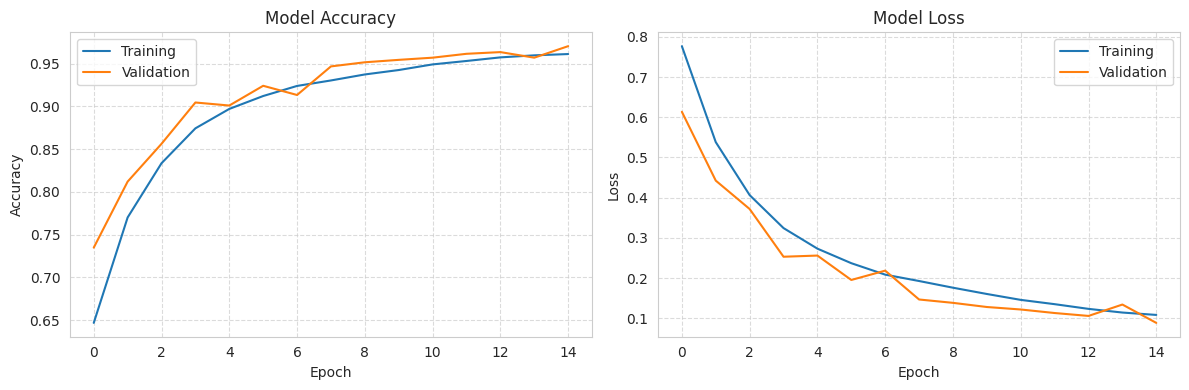

In [44]:
evaluate_and_plot(model_aug, validation_dataset_aug, history_aug)

### Evaluation and Learning Curves Analysis  

Evaluation on the augmented dataset yields a final **Accuracy of 97.03%** and a **Loss of 0.0885**.

The learning curves show very smooth behavior. Training accuracy increases steadily, and validation accuracy remains consistently higher than training accuracy for most epochs. Validation loss also stays slightly below training loss. Small fluctuations appear around Epoch 6, but the overall trend remains stable, reaching minimum loss values close to 0.08.

This configuration shows the highest performance among the three strategies. However, given the high accuracy and the consistent advantage of validation over training metrics, the results warrant closer inspection.

### Classification Report & Confusion Matrix


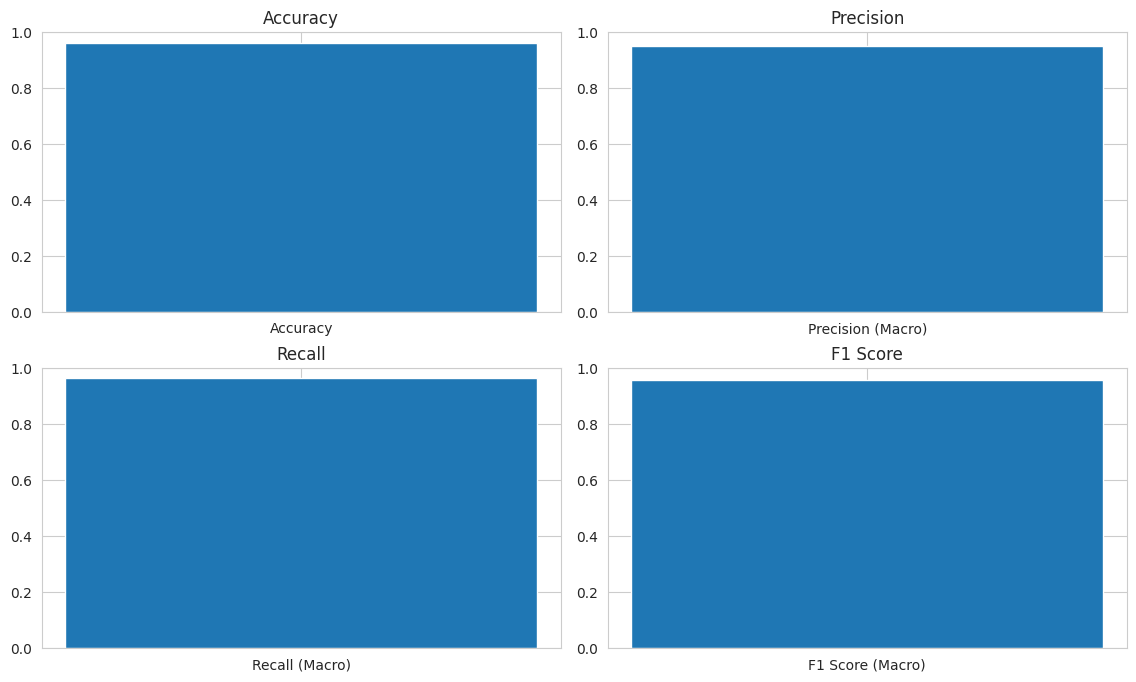

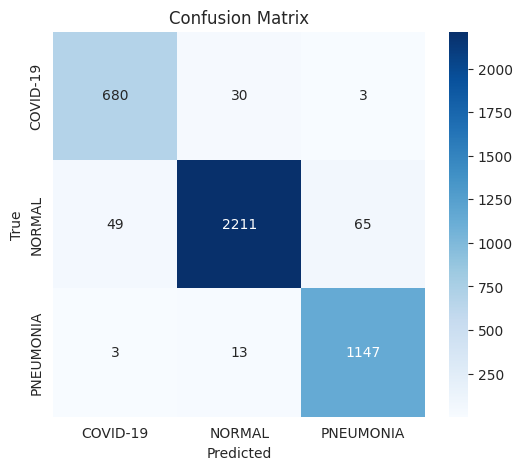


Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.95      0.94       713
      NORMAL       0.98      0.95      0.97      2325
   PNEUMONIA       0.94      0.99      0.96      1163

    accuracy                           0.96      4201
   macro avg       0.95      0.96      0.96      4201
weighted avg       0.96      0.96      0.96      4201



In [45]:
clases = ['COVID-19', 'NORMAL', 'PNEUMONIA']
plot_model_mosaic(model_aug, val_ds_weight, clases)

### Classification Report & Confusion Matrix Analysis  

The classification report and confusion matrix on the 4,201 validation images show an overall **96% accuracy**.

COVID-19 recall reaches 0.95  and PNEUMONIA recall is 0.99. `NORMAL` recall is 0.95. Cross-confusion between the two diseases is minimal: 3 COVID-19 case is predicted as PNEUMONIA and 3 pneumonia cases as COVID-19.

The remaining errors are concentrated in false negatives and a smaller number of false positives.

Compared to the previous strategies, this configuration shows high recall and high precision simultaneously.

However, these high metrics led to a closer inspection of the setup, as the consistently superior validation performance was not typical.

After reviewing, it became clear that augmentation had been applied offline to the entire dataset before performing the train/validation split. As a result, transformed versions of validation images were unintentionally included in the training set. In practice, the model was exposed to augmented variants of validation samples during training, which explains the inflated performance and indicates that the results do not reflect true generalization.

### 9.3 Conclusion: Augmentation Test   

The augmentation strategy initially showed the highest performance, reaching 97% overall accuracy. Training and validation curves were smooth, and the classification metrics indicated high recall together with high precision. Compared to the previous experiments, this configuration appeared to be the best one.

However, after reviewing it was confirmed that augmentation had been applied before splitting the dataset. This caused augmented versions of validation images to appear in the training set. As a result, the reported 97% accuracy probably reflects exposure to transformed variants of validation samples rather than strict generalization to unseen data.

To obtain a valid evaluation, the dataset must first be split into training and validation subsets using only original images. Augmentation should then be applied exclusively to the training subset.

## 10. Final Project Conclusion

The project succesfully developed and evaluated a CNN to classify chest X-rays into NORMAL, PNEUMONIA and COVID-19, but the key takeaway is that the data pipeline (shuffling, splitting, and handling class imbalance) had as much impact on reliable results as the model architecture. When shuffling was disabled during the train/validation split, the validation set became biased toward the majority class, which produced misleading metrics such as near-zero recall for missing classes and an inflated overall accuracy. It was clear that accuracy alone is insufficient under class imbalance, so recall/F1 and the confusion matrix are essential.

To address class imbalance, multiple strategies were tested and the weighted approach (class weighting) was preferred for a medical context because it reduces false negatives in disease classes, prioritizing sensitivity even if it increases some false positives in NORMAL. The undersampling method was also evaluated by downsampling the majority NORMAL class to match PNEUMONIA (5,618 samples), which produced stable training dynamics and good precision, but it reduced COVID-19 recall (around 0.80) and increased false negatives (e.g., many COVID-19 cases predicted as NORMAL), which is risky in healthcare screening scenarios.

Augmentation initially achieved very high performance (97%), but it was not selected because augmentation was applied before splitting, causing data leakage (augmented variants of validation images appearing in training) and therefore an overly optimistic evaluation that did not reflect true generalization.

